# Milestone 3 - ADAVENGERS 2023

# Importing data

In [167]:
#Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats import diagnostic
import re
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
from wordcloud import WordCloud
from transformers import pipeline
import plotly.express as px
import plotly.graph_objects as go
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk



Here we import the csv that were cleaned in milestones 2. For more information you can check out milestone 2

In [2]:
dfcharacter = pd.read_csv("data/dfcharacter_cleaned.csv",index_col=0)

In [24]:
women_nb = len(dfcharacter[dfcharacter["Gender"]== "F"])
men_nb = len(dfcharacter[dfcharacter["Gender"]== "M"])

In [25]:
pastel_pink = '#FFC0CB'
pastel_blue = '#ADD8E6'
fig = px.pie( values=[women_nb,men_nb], names=["Women","Men"], title='Gender proportion in movies',color_discrete_sequence=[pastel_pink, pastel_blue])
fig.write_html("figures/Gender_proportion_pastel.html")

Text(0.5, 1.0, 'Proportion of actors and actress in the character dataset')

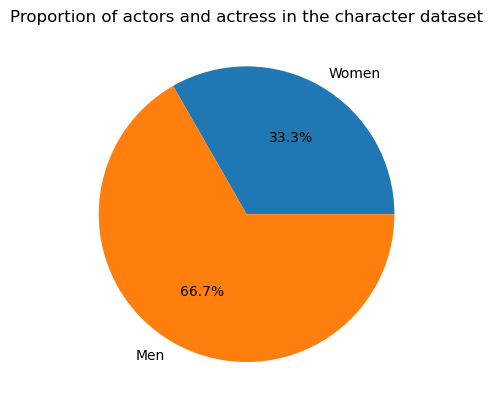

In [26]:
plt.pie(x = [women_nb,men_nb],labels = ["Women","Men"],autopct='%1.1f%%')
plt.title("Proportion of actors and actress in the character dataset")

We observe that there are 2 thirds of actors that are men. there is a clear disparity in frequency representation. We are now interested in how differently women and men are described by words

# Word analysis

In [11]:
df_name_gender = dfcharacter.loc[:, ["Character_name", "Gender"]].dropna()
df_name_gender.columns = ['Name','Gender']
print(df_name_gender.head(5))


                         Name Gender
0                    Akooshay      F
1  Lieutenant Melanie Ballard      F
2         Desolation Williams      M
3          Sgt Jericho Butler      M
4             Bashira Kincaid      F


### Extract word defining women and men

Build a name dict with the character csv name dataset

In [12]:
# build a name dict 
name_list = dfcharacter.loc[:, ["Character_name"]].dropna()
name_list=name_list.squeeze().tolist()
name_dict = set()
for item in list(name_list):
    names = item.split()
    for name in names:
            name_dict.add(name.lower())

Extract list of common words used only to refer to men and another to refer to women

In [13]:
# English vocabulary specific to a certain gender
# female_nouns.txt contains common words that are only used to refer to females, like 'mother'
female_words=set()
with open('data/female_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                female_words.add(word.lower())                
                
# male_nouns.txt contains common words that are only used to refer to males, like 'uncle'     
male_words=set()
with open('data/male_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                male_words.add(word.lower())

Exctract character names and the gender associated

In [14]:
# Define a list of words representing females/males
# females
df_female_name = df_name_gender[df_name_gender['Gender']=='F']['Name']
female_name_dict = set()
for item in df_female_name:
    names = item.split()
    for name in names:
        # remove the names like 'Alice's father' that can have a negative impact on the result
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                female_name_dict.add(name.lower())
female_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in female_name_dict]


# males
df_male_name = df_name_gender[df_name_gender['Gender']=='M']['Name']
male_name_dict = set()
for item in df_male_name:
    names = item.split()
    for name in names:
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                male_name_dict.add(name.lower())
male_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in male_name_dict]

Only keep names which are associated to a specific gender and remove mixt names.

In [15]:
#some characters have the same family name but different gender,remove the family names
female_name_dict_cleaned = set(female_cleaned_list)
male_name_dict_cleaned = set(male_cleaned_list)

intersection_set = male_name_dict_cleaned & female_name_dict_cleaned
male_name_dict = male_name_dict_cleaned - intersection_set
female_name_dict = female_name_dict_cleaned - intersection_set
cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in name_dict]
print(len(cleaned_list))
cleaned_list = set(cleaned_list) - intersection_set
print(len(cleaned_list))

68422
53838


Merged words used only to describe women and the name list

In [16]:
# a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict

Remove words that are also common adjectives from the list

In [17]:
# remove adjs in the name list
adjs_set = set()
with open('data/common_adjs.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        adjs_set.add(word)
female_names_words = female_names_words - adjs_set
male_names_words = male_names_words - adjs_set

Preprocess the text by removing stopwords 

In [18]:
# data preprocessing
# Set the stopwords
stop_words = set(stopwords.words('english'))

# function used to tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ['she' if word in female_names_words else 'he' if word in male_names_words else word for word in text.split() if word not in stop_words]


In [19]:
dfsummaries = pd.read_csv('data/dfsummaries_cleaned.csv')
df_cleaned_summary = dfsummaries["Summary"].apply(lambda x : preprocess_text(x))
# apply the fuction to the summaries
dfsummaries

,Unnamed: 0,Wikipedia_ID,Summary,Summary_Length
0,0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178
1,1,31186339,The nation of Panem consists of a wealthy Capi...,4559
2,2,20663735,Poovalli Induchoodan is sentenced for six yea...,3101
3,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917
4,4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425
...,...,...,...,...
42290,42298,34808485,"The story is about Reema , a young Muslim scho...",220
42291,42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971
42292,42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871
42293,42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289


In [24]:
documents = list(df_cleaned_summary)

## Adjective extraction

In [ ]:

# 
female_name_dict = []
with open('data/female_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        female_name_dict.append(line.strip())
female_name_dict=set(female_name_dict)
male_name_dict = []
with open('data/male_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        male_name_dict.append(line.strip())
male_name_dict=set(male_name_dict)

# data preprocessing, very time-consuming

# Define a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict
remove_dict=(stop_words | female_names_words | male_names_words)
#from https://www.merriam-webster.com/thesaurus/

def preprocess_text_adj(text):
    # lower the words and remove punctuation
    text_token = word_tokenize(text)
    tagged = pos_tag(text_token)
    adjectives = [word for word, pos in tagged if (pos.startswith('JJ'))]
    text = [word.lower() for word in adjectives if word.isalpha()]
    # tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords.
    return [word for word in text if word not in remove_dict]

documents_adj=[]
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    for line in file:
        text = line
        documents_adj.append(preprocess_text_adj(text))
documents_adj = [word for sublist in documents_adj for word in sublist]

Only keeping adjectives appearing more than once

In [ ]:
vocabulary=list(set(documents_adj))
adj_counts = {word: documents_adj.count(word) for word in vocabulary}
adj_count_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
# only use the words appear at least twice
documents_adj=list(adj_count_df[adj_count_df['Count']>1]['Word'])

In [ ]:
adj_count_df.to_csv("data/adj_count.csv")

Remove the words that are classified are adjectives which aren't

In [ ]:
# remove some words in case of incorrect classification
lines = []

# file from https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/

with open('data/female name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)

lines = []
with open('data/male name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)


lines = []


print(len(documents_adj))
other_common_words = set(['child', 'orphan', 'baby', 'girls', 'lover', 'mute','child', 'orphan', 'bride', 
                          'baby', 'girls', 'lover', 'mute', 'housekeeper', 'cousin', 'neighbour', 'parent', 
                          'sibling', 'pregnant', 'housewife', 'relative', 'servant', 'waif', 'grandson', 
                          'stranger', 'courtesan', 'servant','cousin', 'neighbour', 'parent', 'sibling', 
                          'housewife','nurse', 'stepsister', 'housekeeper','grandson','servant','grandchildren',
                          'relatives', 'uncles', 'orphans', 'childbirth', 'scoundrel', 'foreigner', 'stepfamily', 
                          'tuberculosis', 'mallaya', 'triplet', 'grandchildren', 'outcast', 'neighbours', 'huanhuan', 
                          'lakshmiammal', 'jaipal', 'himal', 'pasarian', 'leukemia'])
documents_adj = set(documents_adj)-set(other_common_words)

8644


In [ ]:
# save data
with open('data/adjectives.txt', 'w', encoding='utf-8') as file:
    for item in documents_adj:
        file.write(item + '\n')

In [58]:
# load the data adjectives.txt (extracted from the text)
adjectives = []
with open('data/adjectives.txt', 'r', encoding='utf-8') as file:
    for line in file:
        adjectives.append(line.strip())

## Train model

In [21]:
# train the word2vec model
model = Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

# save the model
model.save("word2vec.model")

In [113]:
# apply the model
model = Word2Vec.load("word2vec.model")
adjectives = [word for word in adjectives if word in model.wv.key_to_index]
adj_vectors = [model.wv[word] for word in adjectives]
vector_she = model.wv['she']
vector_he = model.wv['he']

## Ajectives analysis

### Calculate Cosine similarities 

In [114]:
# example: lovely
similarity = cosine_similarity(vector_she.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between female and lovely: {similarity}')
similarity = cosine_similarity(vector_he.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between male and lovely: {similarity}')

similarity between female and lovely: [[0.43818724]]
similarity between male and lovely: [[0.20128304]]


In [115]:
female_reference_vector = vector_she.reshape(1, -1)
female_similarities = [cosine_similarity(female_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]
male_reference_vector = vector_he.reshape(1, -1)
male_similarities = [cosine_similarity(male_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]

In [136]:
similaritie = pd.DataFrame()
similarity_and_frequency = pd.DataFrame()

In [137]:
similaritie = pd.DataFrame({'Female':female_similarities,'Male':male_similarities})
similaritie.index=adjectives

In [138]:
similaritie.sort_values(by=['Male'], ascending= False)

,Female,Male
he,0.844037,1.000000
she,1.000000,0.844037
unfortunately,0.495716,0.538401
unfortunately,0.495716,0.538401
stopped,0.410014,0.527719
...,...,...
directed,-0.202042,-0.200106
geothermal,-0.371462,-0.253322
geothermal,-0.371462,-0.253322
de,-0.270370,-0.356519


Adding to the dataframe the appearance frequency

In [139]:
adj_count_df = pd.read_csv("data/word_count_df.csv",index_col =0)
adj_count_df

,Word,Count
0,chose,168
1,forced,3804
2,uncontrolled,9
3,vocabulary,13
4,pyrokinetic,7
...,...,...
8643,sequential,6
8644,unfreeze,6
8645,imprison,48
8646,he,1133797


In [144]:
similarity_and_frequency = adj_count_df.merge(similaritie, left_on ="Word",right_index = True )
similarity_and_frequency = similarity_and_frequency.drop_duplicates()

In [121]:
men_nb = int(adj_count_df.loc[adj_count_df["Word"] =="he"]["Count"])
women_nb = int(adj_count_df.loc[adj_count_df["Word"] =="she"]["Count"])

C:\Users\aaugr\AppData\Local\Temp\ipykernel_8732\1296177445.py:1: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\aaugr\AppData\Local\Temp\ipykernel_8732\1296177445.py:2: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [122]:
pastel_pink = '#FFC0CB'
pastel_blue = '#ADD8E6'
fig = px.pie( values=[women_nb,men_nb], names=["Women","Men"], title='Proportion of the genders mentionned in the summaries',color_discrete_sequence=[pastel_pink, pastel_blue])
fig.write_html("figures/Gender_proportion_protagonist_pastel.html")

Text(0.5, 1.0, 'Proportion of the genders mentionned in the summaries')

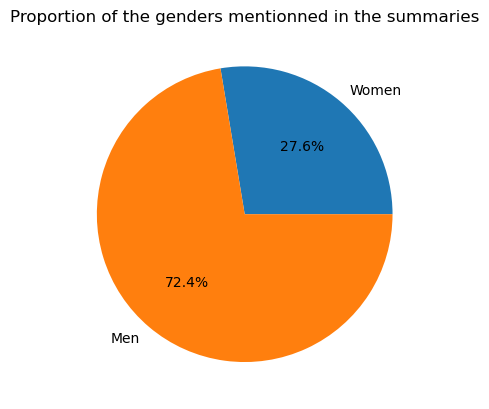

In [123]:
plt.pie(x = [women_nb,men_nb],labels = ["Women","Men"],autopct='%1.1f%%')
plt.title("Proportion of the genders mentionned in the summaries")

We observe that men are mentioned much more than women which is expected. 

Interestingly  he and she have very close cosine distance (0.859739). Probably as they are both pronouns and as following the transformations made in the dataset they are both very present in the dataset. We however remove them  in the following analysis as they are not adjectives.

In [145]:
similarity_and_frequency = similarity_and_frequency.drop([8646,8647])

In [146]:
similaritie = similaritie.drop(["he","she"])

Let's now look at which adjectives are most closely related to women and which are closely related to men.

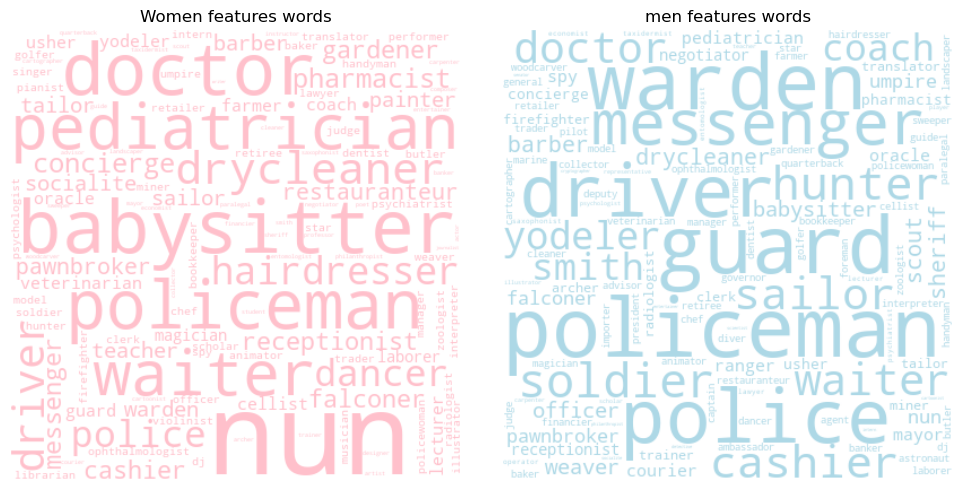

In [201]:
word_sim_female = {word: sim for word, sim in similaritie["Female"].items()}
word_sim_male = {word: sim for word, sim in similaritie["Male"].items()}

def plot_wordclouds(word_sim_female,word_sim_male, path,title):

    wordcloud_female = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: pastel_pink).generate_from_frequencies(word_sim_female)
    wordcloud_male = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: pastel_blue).generate_from_frequencies(word_sim_male)

    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_female, interpolation='bilinear')
    plt.title('Women features words')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_male, interpolation='bilinear')
    plt.title('men features words')
    plt.axis('off')

    
    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig("figures/"+ path )
    plt.show()
plot_wordclouds(word_sim_female,word_sim_male, "wordcloud_just_adjectives.png", "")


It's a bit hard to get something out of this data as they are lots of non adjectives words. Even if we see more "emotional adjectives" in the women part (overjoyed, confused, sorry, ashamed) that don't see to appear in the men plot. 
However some words describe women and men at the same time (thanksfully) and don't represent the possible gender bias that are to be observed. We thus decided to observe the words with biggest difference between men and women cosine similarities.

In [202]:
similarity_diff=similaritie['Female']-similaritie['Male']
top_100_female_adj = similarity_diff.sort_values(ascending=False).head(100).index
top_100_male_adj = similarity_diff.sort_values(ascending=True).head(100).index

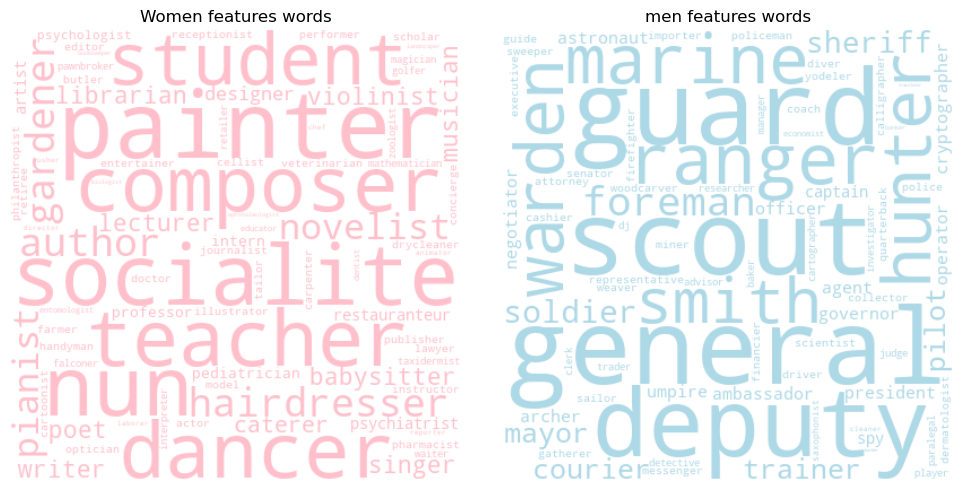

In [203]:
from wordcloud import WordCloud



word_sim_female = {word: sim for word, sim in similarity_diff.items()}
word_sim_male = {word: -sim for word, sim in similarity_diff.items()}

plot_wordclouds(word_sim_female,word_sim_male, "wordcloud_diff_adjectives.png", "")


Woh now that's some results it seems that the vocabluary of war is much more present in words that are more related to men compared to words more related to women. While women are described with words more related to relations ("loving","lonely","caring", "divorced","overprotective","charming", "fiancée"..).

Let's now have a closer look at word that are the most different between men and women and their frequency.

In [204]:
similarity_and_frequency["diff"] = similarity_and_frequency["Female"] - similarity_and_frequency["Male"]
similarity_and_frequency.sort_values(by = "diff", ascending=False).head(10)

,Word,Count,Female,Male,diff,abs_diff
8053,loving,556,0.430324,0.139540,0.290784,0.290784
7175,neighbor,822,0.318647,0.050497,0.268150,0.268150
4394,somewhat,499,0.253015,-0.013017,0.266032,0.266032
6209,beautiful,2430,0.316897,0.054275,0.262622,0.262622
8028,unhappy,526,0.456288,0.196661,0.259627,0.259627
6426,lonely,652,0.439135,0.185254,0.253881,0.253881
7983,shy,429,0.187075,-0.062799,0.249873,0.249873
6439,overprotective,98,0.384818,0.135949,0.248869,0.248869
2426,worrisome,6,0.343534,0.095021,0.248513,0.248513
4423,lifestyle,682,0.209226,-0.036226,0.245452,0.245452


In [205]:
similarity_and_frequency["abs_diff"] = np.abs(similarity_and_frequency["diff"])
similarity_and_frequency.sort_values(by = "abs_diff", ascending=False).head(20)

,Word,Count,Female,Male,diff,abs_diff
1735,cannon,356,-0.050976,0.243705,-0.294681,0.294681
8053,loving,556,0.430324,0.139540,0.290784,0.290784
2524,tank,663,-0.043307,0.241340,-0.284647,0.284647
1430,armed,840,-0.011135,0.269560,-0.280695,0.280695
4384,bombs,412,-0.075809,0.193429,-0.269238,0.269238
4799,artillery,180,-0.167524,0.101370,-0.268894,0.268894
1867,automatic,103,-0.075634,0.192619,-0.268252,0.268252
7175,neighbor,822,0.318647,0.050497,0.268150,0.268150
4503,loaded,262,0.017448,0.284624,-0.267176,0.267176
4394,somewhat,499,0.253015,-0.013017,0.266032,0.266032


In [206]:
similarity_and_frequency.sort_values(by = "abs_diff", ascending=True).head(20)

,Word,Count,Female,Male,diff,abs_diff
539,undeterred,60,0.288945,0.288945,-5.066395e-07,5.066395e-07
464,linked,160,0.012008,0.012003,5.789101e-06,5.789101e-06
2051,renovated,25,0.030531,0.030489,4.276820e-05,4.276820e-05
3771,perjured,5,0.119170,0.119126,4.349649e-05,4.349649e-05
488,mystical,103,0.059383,0.059428,-4.545972e-05,4.545972e-05
2492,jazzy,6,0.111754,0.111707,4.692376e-05,4.692376e-05
8581,except,1076,0.342701,0.342654,4.732609e-05,4.732609e-05
933,former,4386,0.057202,0.057250,-4.811957e-05,4.811957e-05
80,underdeveloped,9,0.004892,0.004843,4.894752e-05,4.894752e-05
671,hippocratic,2,0.150077,0.150028,4.899502e-05,4.899502e-05


In [207]:
print(f'Max cosine similiraty with women {similarity_and_frequency["Female"].max()}')
print(f'Min cosine similiraty with women {similarity_and_frequency["Female"].min()}')
print(f'Max cosine similiraty with men {similarity_and_frequency["Male"].max()}')
print(f'Mincosine similiraty with men {similarity_and_frequency["Male"].min()}')

Max cosine similiraty with women 0.5941349267959595
Min cosine similiraty with women -0.3714624047279358
Max cosine similiraty with men 0.5384011268615723
Mincosine similiraty with men -0.3565189242362976


In [208]:
print(f'Possible max range : {similarity_and_frequency["Female"].max() -similarity_and_frequency["Female"].min()} ')

Possible max range : 0.9655973315238953 


The adjectives that are most different between men and women have cosine differences of around 0.25 while the biggest possible difference between the words is of 0.96. Therefore we need to keep in mind that even if the words we are looking at are the most different the differences are relatively small compared to the possible differences between words. Which is actually great news because the gender gap is not that big. However a difference of 0.25 is still consequent and the results clearly show expected outputs from gender social norms. 
The words that have lowest differences are close to 0, they are very similar. Supprisingly we can find the words muscled and muscular in those words that don't have much difference while we would expect them to be more closely correlated with men than women.

We also observe that some words don't appear a lot. The training of the dataset on those word is probably not very meaningful we thus decide to remove all words appearing less than 50 times and to observe only those. 

In [209]:
similarity_and_frequency_above_50 = similarity_and_frequency[similarity_and_frequency["Count"]>50].drop_duplicates()

In [210]:
similaritie = similaritie.loc[similarity_and_frequency_above_50["Word"]].drop_duplicates()

KeyError: "['chose', 'forced', 'remarried', 'canary', 'unfaithful', 'fiancée', 'destitute', 'affect', 'unsuccessfully', 'chinatown', 'inspired', 'lebanese', 'suspense', 'wagon', 'identical', 'intended', 'orphaned', 'crossed', 'disoriented', 'stole', 'ex', 'remote', 'pressured', 'forgiveness', 'appointed', 'barred', 'control', 'blindness', 'bolt', 'woo', 'stripped', 'civil', 'teens', 'local', 'isolated', 'ridden', 'family', 'hapless', 'refused', 'otherwise', 'discouraged', 'demonic', 'extensive', 'delighted', 'slashed', 'embedded', 'motivated', 'wayward', 'anymore', 'employed', 'ideal', 'plus', 'inspiring', 'mystery', 'ss', 'stated', 'departing', 'mid', 'cooked', 'sabotage', 'bungalow', 'resemble', 'tiny', 'ordered', 'unsure', 'surprising', 'misunderstood', 'internet', 'dearly', 'convicted', 'rural', 'tournament', 'reduced', 'meat', 'reversed', 'erratic', 'wooden', 'democratic', 'required', 'dependent', 'recital', 'burnt', 'inappropriate', 'seven', 'antisocial', 'wing', 'average', 'spotted', 'individual', 'islamic', 'write', 'similarly', 'monitoring', 'include', 'understanding', 'everybody', 'sing', 'joint', 'grim', 'adversary', 'little', 'reminded', 'strangled', 'purely', 'android', 'drifter', 'muddy', 'controlled', 'tonight', 'assured', 'undergoing', 'european', 'bullied', 'signed', 'alarmed', 'squirrel', 'speed', 'substitute', 'sweeping', 'okay', 'stepping', 'printing', 'immigrant', 'disposed', 'bloodied', 'wound', 'loft', 'faster', 'ridiculous', 'feigns', 'test', 'bin', 'encouragement', 'repeated', 'careless', 'mini', 'leave', 'locked', 'permanent', 'pointed', 'flying', 'hop', 'nri', 'assistant', 'giant', 'eligible', 'guided', 'ashamed', 'baffled', 'urge', 'persistent', 'touch', 'betrayal', 'appealing', 'agree', 'riding', 'magical', 'pulse', 'ardent', 'unwelcome', 'karaoke', 'obliged', 'millionaire', 'macho', 'pumpkin', 'assembled', 'passionate', 'young', 'illegitimate', 'framed', 'anticipated', 'perspective', 'swarm', 'ship', 'bearded', 'chicken', 'seizes', 'absent', 'middle', 'dismissed', 'predicted', 'betrothed', 'confronted', 'remarkable', 'magnetic', 'linked', 'puppet', 'fifteen', 'renegade', 'large', 'athletic', 'rush', 'washed', 'tourist', 'beast', 'mystical', 'autograph', 'changed', 'repaired', 'incompetent', 'arranged', 'planned', 'agricultural', 'selfishness', 'limo', 'forth', 'obvious', 'crusty', 'awful', 'outburst', 'honors', 'least', 'completely', 'highest', 'illicit', 'diet', 'hockey', 'please', 'republican', 'warm', 'undeterred', 'interrupts', 'overwhelming', 'whereupon', 'ancestral', 'second', 'whale', 'medal', 'silly', 'injure', 'twisted', 'active', 'sought', 'sample', 'hilarious', 'basic', 'tropical', 'title', 'distract', 'duck', 'eagle', 'electrical', 'musical', 'locate', 'animated', 'ah', 'oppressive', 'lifelong', 'incident', 'addicted', 'jazz', 'underworld', 'punished', 'amputated', 'randomly', 'dome', 'gang', 'camper', 'blame', 'elegant', 'skilled', 'matter', 'air', 'sacrifice', 'chronic', 'occupied', 'cello', 'questionable', 'theatre', 'persona', 'reserved', 'bedside', 'illness', 'escort', 'unsolved', 'upsets', 'unnecessary', 'devout', 'downstairs', 'historical', 'occupying', 'renowned', 'videos', 'entranced', 'logic', 'character', 'karate', 'fate', 'frantic', 'calm', 'unhappily', 'unwitting', 'truth', 'heist', 'reunited', 'meek', 'angered', 'unscathed', 'quarantine', 'kindhearted', 'superhero', 'fluid', 'psychopathic', 'amusing', 'den', 'evil', 'ángel', 'spiritual', 'listed', 'acting', 'makeshift', 'rehab', 'tooth', 'already', 'complicated', 'great', 'unfortunate', 'intimate', 'freezer', 'sick', 'smashed', 'poles', 'wandering', 'night', 'amnesia', 'small', 'progressive', 'grotesque', 'stronger', 'throw', 'cult', 'contest', 'album', 'deformed', 'vulnerable', 'interfere', 'deep', 'minus', 'racial', 'north', 'branch', 'twin', 'brown', 'wired', 'upstairs', 'steady', 'sometime', 'idealistic', 'provocative', 'smitten', 'angels', 'thorne', 'steep', 'established', 'denial', 'spectre', 'transport', 'nandu', 'cellar', 'awarded', 'tar', 'betray', 'former', 'ghostly', 'horrified', 'theme', 'classmate', 'climbs', 'commercial', 'lab', 'respected', 'drained', 'sneaks', 'round', 'stubbornly', 'sober', 'faulty', 'framing', 'forbidden', 'archive', 'slain', 'amorous', 'coastal', 'acquired', 'specimen', 'enough', 'impulsive', 'aerial', 'endless', 'proposed', 'elected', 'manor', 'unharmed', 'type', 'explicit', 'chest', 'narrating', 'daily', 'base', 'soaked', 'legs', 'remind', 'difficult', 'usual', 'swear', 'fictional', 'story', 'midnight', 'sultan', 'yogi', 'goodbye', 'divorced', 'trouble', 'ostracized', 'imminent', 'interrupt', 'fabric', 'dwarf', 'filthy', 'intact', 'disable', 'momentarily', 'somebody', 'rebuilt', 'scale', 'fiancé', 'keep', 'arsenal', 'whispering', 'address', 'accustomed', 'dragon', 'argue', 'overbearing', 'possess', 'end', 'yuan', 'banana', 'ancient', 'bother', 'nickname', 'asteroid', 'fulfilling', 'toy', 'showdown', 'pike', 'fabulous', 'noticed', 'gym', 'restricted', 'normal', 'upon', 'married', 'snake', 'elusive', 'army', 'battlefield', 'racist', 'mall', 'celebrate', 'humanoid', 'bounty', 'complete', 'depth', 'hammer', 'immensely', 'plague', 'extraterrestrial', 'continuous', 'electronic', 'startling', 'cleverly', 'repeating', 'hometown', 'emotional', 'strained', 'ate', 'oh', 'elf', 'body', 'born', 'playboy', 'undergoes', 'returned', 'paranoia', 'legitimate', 'caring', 'bean', 'attendant', 'wherever', 'connecting', 'ultimatum', 'dear', 'bomb', 'titled', 'answering', 'thwart', 'confused', 'rebel', 'investigating', 'lakh', 'praised', 'scattered', 'atomic', 'talent', 'porn', 'stationed', 'café', 'obey', 'spilled', 'christmas', 'confidant', 'adjacent', 'singing', 'locomotive', 'brothel', 'collective', 'ferry', 'ice', 'needing', 'arctic', 'heartless', 'galactic', 'distinct', 'missed', 'prostitute', 'submerged', 'encouraged', 'strong', 'protect', 'recipe', 'afterlife', 'occult', 'purpose', 'planted', 'superhuman', 'lighthearted', 'theater', 'spoiled', 'accept', 'ramshackle', 'immune', 'upsetting', 'hurls', 'terrifying', 'realm', 'sermon', 'penniless', 'caboose', 'penitentiary', 'quality', 'humorous', 'bug', 'lovely', 'tyrannical', 'deadly', 'pleasant', 'famed', 'subtle', 'feed', 'become', 'ferris', 'wall', 'map', 'meteorite', 'stark', 'nonetheless', 'storyline', 'magic', 'trail', 'armed', 'decide', 'unstable', 'hoax', 'twelve', 'stare', 'oppose', 'conflicting', 'premature', 'harshly', 'rhythm', 'departed', 'incomplete', 'us', 'cop', 'disfigured', 'real', 'initiate', 'bite', 'identify', 'voiceover', 'cloning', 'misunderstanding', 'evacuated', 'downed', 'bedridden', 'closeted', 'willing', 'lucrative', 'survival', 'bumbling', 'accessed', 'assaulted', 'pig', 'close', 'hug', 'warmly', 'relentless', 'respective', 'polite', 'smaller', 'sharp', 'jump', 'stirs', 'speeding', 'skyscraper', 'irritated', 'descendant', 'snobbish', 'anniversary', 'expected', 'volunteer', 'fearsome', 'sung', 'effective', 'bosnian', 'central', 'portable', 'epilogue', 'failing', 'alongside', 'fruitless', 'rooftop', 'dumped', 'personal', 'hedonistic', 'dating', 'calmly', 'previous', 'smoke', 'promoted', 'mounted', 'cardinal', 'ecstasy', 'narrator', 'wealthy', 'genre', 'impaled', 'build', 'buys', 'banjo', 'overhead', 'charming', 'restrained', 'frog', 'risky', 'chandelier', 'destroys', 'widower', 'broken', 'shop', 'acted', 'carefree', 'commandant', 'touring', 'shatter', 'homosexual', 'feared', 'undertake', 'commit', 'peasant', 'evicted', 'lo', 'act', 'babysitting', 'enslaved', 'sadness', 'material', 'deciding', 'inflicted', 'role', 'controlling', 'studied', 'cannon', 'ape', 'away', 'absolute', 'besieged', 'bleeding', 'hostage', 'flute', 'feisty', 'choose', 'rubble', 'welcoming', 'northwest', 'begin', 'orb', 'healing', 'understand', 'treacherous', 'unrequited', 'lived', 'distraught', 'sedative', 'glass', 'peer', 'agreed', 'atop', 'jailed', 'suresh', 'neutral', 'incestuous', 'competitive', 'train', 'funny', 'suggested', 'dimwitted', 'n', 'represent', 'stolen', 'burst', 'unnoticed', 'repulsed', 'sat', 'resolved', 'naming', 'falls', 'mature', 'unnatural', 'striking', 'spill', 'automatic', 'cathedral', 'audio', 'climactic', 'briefly', 'protagonist', 'retrieved', 'seductive', 'pain', 'opened', 'increased', 'text', 'awaken', 'contaminated', 'upperclass', 'executed', 'military', 'sadistic', 'conflicted', 'suburban', 'weakened', 'reject', 'damaged', 'pretend', 'background', 'handicapped', 'cultural', 'alpha', 'enduring', 'temper', 'secret', 'unorthodox', 'threaten', 'mundane', 'pillar', 'forgotten', 'accomplice', 'professional', 'depths', 'included', 'destroyed', 'stopping', 'cloud', 'troublesome', 'folk', 'dummy', 'eighth', 'obnoxious', 'grand', 'greater', 'narrow', 'impoverished', 'terrorized', 'contemporary', 'ominous', 'thief', 'mischievous', 'communal', 'cbi', 'claimed', 'presumably', 'flood', 'presumed', 'lethal', 'ballet', 'israeli', 'spinning', 'rainbow', 'distracted', 'wan', 'lesson', 'murderous', 'level', 'robbery', 'diplomatic', 'clue', 'resident', 'timid', 'tattoo', 'perpetual', 'victorious', 'assemble', 'popcorn', 'escalating', 'assaults', 'optimistic', 'ups', 'iceberg', 'consummate', 'spending', 'dressing', 'manned', 'feudal', 'satya', 'ignorant', 'return', 'sailing', 'bust', 'flips', 'swimming', 'selfish', 'outspoken', 'laboratory', 'pizza', 'canadian', 'initial', 'cleared', 'losing', 'postman', 'guilty', 'looked', 'centre', 'fireworks', 'bartender', 'everyday', 'villainous', 'environmental', 'sum', 'unimpressed', 'murdering', 'photographed', 'forbids', 'freezes', 'robs', 'sneak', 'purse', 'permitted', 'pursued', 'frogs', 'remembered', 'younger', 'wedding', 'newest', 'inhabited', 'embittered', 'biblical', 'grocery', 'clown', 'photographs', 'prize', 'boxing', 'deprived', 'memorial', 'ask', 'classical', 'bring', 'exploded', 'fearful', 'worldly', 'chemical', 'kidnap', 'handle', 'fake', 'oak', 'behaviour', 'harrowing', 'delirious', 'time', 'late', 'dazed', 'erupt', 'orphanage', 'comic', 'geek', 'supernatural', 'proud', 'demo', 'lead', 'attachment', 'watchful', 'intensely', 'frontier', 'teaching', 'intent', 'cops', 'genetic', 'coaching', 'sworn', 'youngster', 'flooding', 'robot', 'ten', 'spent', 'flirtatious', 'greatest', 'metro', 'trusted', 'accomplished', 'blomkvist', 'hair', 'horrifying', 'influenced', 'improvised', 'perilous', 'dedicated', 'sour', 'crude', 'idle', 'boiling', 'invisible', 'lifetime', 'unspecified', 'compete', 'honored', 'senseless', 'struck', 'couple', 'call', 'descent', 'townspeople', 'necessary', 'strangely', 'panicked', 'unfair', 'conman', 'black', 'tired', 'movie', 'fitting', 'religious', 'aroused', 'resurrected', 'plead', 'partial', 'tenant', 'czech', 'church', 'rumored', 'east', 'smuggled', 'let', 'stagecoach', 'inner', 'respect', 'mon', 'incoming', 'teen', 'instant', 'extracted', 'slipped', 'spreading', 'fascinated', 'bare', 'kindly', 'psychotic', 'runaway', 'amused', 'vanished', 'hiking', 'rather', 'convertible', 'possessed', 'realizes', 'homemade', 'iron', 'maximum', 'lengthy', 'admitted', 'gifted', 'challenged', 'ankle', 'new', 'tank', 'turning', 'consumed', 'stunning', 'unexpected', 'cheap', 'recaptured', 'parisian', 'devastated', 'blackmailed', 'grueling', 'opening', 'various', 'misfit', 'eventual', 'adulthood', 'overheard', 'nationwide', 'testing', 'souls', 'frighten', 'evades', 'heavy', 'capture', 'das', 'passionately', 'iqbal', 'shuttle', 'unravel', 'bruised', 'lower', 'alarm', 'epidemic', 'key', 'bohemian', 'reminiscent', 'legendary', 'proposing', 'pleas', 'random', 'strictly', 'pleased', 'flooded', 'disheartened', 'soda', 'stressed', 'desk', 'additional', 'goodnight', 'rakesh', 'cheek', 'force', 'lone', 'anu', 'lush', 'club', 'plastic', 'whole', 'drive', 'amazed', 'full', 'user', 'abandon', 'statue', 'expelled', 'found', 'tango', 'underneath', 'intense', 'prosperous', 'weak', 'enchanted', 'shadowy', 'rescued', 'suddenly', 'bonus', 'correct', 'astonished', 'shocked', 'remorseful', 'boys', 'choir', 'watching', 'guerrillas', 'butterfly', 'loudly', 'spread', 'subplots', 'overpowered', 'ambitious', 'albeit', 'guitar', 'sealed', 'subsequently', 'grabs', 'touching', 'nighttime', 'luck', 'sooner', 'scam', 'warp', 'animal', 'smart', 'suffering', 'roommate', 'larger', 'colour', 'prolonged', 'moving', 'angry', 'mainly', 'convince', 'reunite', 'capital', 'whirlwind', 'engulfed', 'forming', 'confined', 'paranormal', 'punish', 'hiding', 'strawberry', 'perfume', 'paths', 'sun', 'climate', 'stunned', 'fight', 'aka', 'surgeon', 'unfamiliar', 'weekly', 'chained', 'tense', 'vet', 'verse', 'seek', 'rude', 'territory', 'talented', 'decided', 'foiled', 'prevent', 'homeless', 'aged', 'vent', 'decoy', 'declare', 'shaman', 'burn', 'eating', 'inn', 'mad', 'tong', 'associated', 'youths', 'burned', 'severely', 'slavery', 'prologue', 'philosophical', 'eerie', 'describes', 'acquitted', 'leading', 'enhanced', 'delivered', 'smalltown', 'marijuana', 'demanded', 'commander', 'origin', 'outnumbered', 'american', 'shark', 'healthy', 'underway', 'desert', 'exiled', 'kid', 'raja', 'subsequent', 'pressed', 'nightmare', 'manuscript', 'enigmatic', 'tavern', 'dubbed', 'shattering', 'entirely', 'dice', 'aborted', 'save', 'flashback', 'chaos', 'unarmed', 'valuable', 'possessive', 'overnight', 'madness', 'protest', 'confiscated', 'license', 'haveli', 'battered', 'scheduled', 'skeleton', 'interspersed', 'defensive', 'distracting', 'properly', 'grade', 'context', 'autumn', 'certain', 'laptop', 'safer', 'panther', 'fine', 'engaging', 'helpless', 'travel', 'vampire', 'arena', 'escaping', 'nose', 'clear', 'triumphs', 'colored', 'covert', 'dreams', 'insulting', 'narayan', 'popular', 'three', 'devoted', 'sacred', 'lotus', 'wicked', 'subway', 'erased', 'decides', 'rundown', 'pinned', 'becomes', 'applied', 'present', 'sweet', 'monster', 'threesome', 'cryptic', 'wrapped', 'shelter', 'asleep', 'acceptable', 'spaceship', 'goblin', 'flaming', 'starring', 'awake', 'jumbo', 'shared', 'murder', 'tub', 'soul', 'true', 'kiss', 'skiing', 'closest', 'lowly', 'leaking', 'stricken', 'fools', 'grounded', 'aware', 'official', 'ravaged', 'sea', 'arrange', 'inmate', 'ndash', 'casual', 'bourne', 'suicide', 'early', 'saddened', 'feature', 'snow', 'entertaining', 'transported', 'convent', 'outgoing', 'attic', 'intimidating', 'beneath', 'tail', 'deaf', 'prank', 'junior', 'phantom', 'good', 'published', 'suspect', 'hearing', 'barbed', 'appropriate', 'prime', 'checked', 'collected', 'endangered', 'feud', 'cheerleading', 'infuriated', 'protected', 'notorious', 'needed', 'seedy', 'social', 'laundry', 'bombing', 'expert', 'targeted', 'buried', 'costume', 'meantime', 'months', 'proof', 'bible', 'growing', 'squad', 'revived', 'knee', 'tribute', 'blonde', 'cavalry', 'owl', 'downward', 'residential', 'whistle', 'sage', 'anguish', 'moonlight', 'dolphin', 'show', 'warhead', 'surreal', 'liberal', 'south', 'contracted', 'ninth', 'telepathic', 'mexican', 'fragile', 'dropped', 'worst', 'nicknamed', 'telling', 'big', 'ritual', 'switched', 'lynch', 'ruined', 'urgent', 'patrolling', 'public', 'dissatisfied', 'revival', 'propose', 'stupid', 'pal', 'flowing', 'qing', 'landing', 'confirmed', 'scholarship', 'feminine', 'searching', 'poisoned', 'posted', 'breathing', 'duplicate', 'widespread', 'cabaret', 'racing', 'marked', 'transplant', 'cancelled', 'spend', 'produced', 'morale', 'genie', 'assigned', 'studying', 'serial', 'indian', 'lakhs', 'siege', 'depressed', 'surfing', 'palestinian', 'cafe', 'ryder', 'educational', 'overwhelmed', 'lengths', 'pair', 'implicated', 'prehistoric', 'torment', 'heartfelt', 'amidst', 'cocky', 'dynamic', 'childless', 'mutual', 'shopkeeper', 'doomed', 'collar', 'deeply', 'fails', 'questioning', 'income', 'tattooed', 'onto', 'travels', 'circus', 'blank', 'vain', 'physics', 'kimble', 'dreyfus', 'future', 'within', 'high', 'ball', 'square', 'monetary', 'remorse', 'stop', 'clique', 'unlikely', 'determined', 'offended', 'vest', 'following', 'inquiry', 'insane', 'frustrated', 'every', 'related', 'archaeologist', 'invade', 'fantasy', 'physical', 'saved', 'entire', 'historic', 'grief', 'exploding', 'bush', 'winning', 'embarrassed', 'heavyweight', 'useless', 'confusing', 'imprisonment', 'dna', 'stamp', 'urges', 'monstrous', 'excessive', 'fun', 'subplot', 'teeth', 'vague', 'schoolteacher', 'poem', 'give', 'nearest', 'spurned', 'cunning', 'confront', 'cornered', 'disrupt', 'alien', 'cant', 'realize', 'sees', 'joking', 'fountain', 'dashing', 'intervene', 'overdose', 'crowd', 'socialist', 'lacking', 'grey', 'scramble', 'thug', 'rounded', 'satanic', 'year', 'typical', 'tortured', 'attempted', 'elder', 'told', 'fall', 'dog', 'inland', 'unaware', 'caught', 'garden', 'revealed', 'energetic', 'posse', 'climbing', 'longtime', 'thwarted', 'principal', 'relax', 'enforcement', 'photographer', 'pornographic', 'committed', 'paralyzed', 'hillside', 'music', 'unfortunately', 'near', 'confessed', 'divine', 'welfare', 'conflict', 'unruly', 'memory', 'bloodshed', 'slight', 'charmed', 'tracking', 'rapid', 'antagonist', 'rebuild', 'breakdown', 'behind', 'dealt', 'scheming', 'bus', 'airplane', 'ill', 'justice', 'fought', 'drastic', 'dramatic', 'farm', 'borrowed', 'momma', 'insecure', 'explode', 'assumed', 'rat', 'deranged', 'meant', 'fistfight', 'strapped', 'attended', 'sixteen', 'ripped', 'uncertain', 'inseparable', 'paternal', 'icy', 'eldest', 'nightclub', 'refugee', 'fallen', 'upside', 'challenge', 'greek', 'fat', 'suspended', 'critic', 'undead', 'smooth', 'nails', 'palatial', 'head', 'swept', 'floating', 'known', 'operated', 'homicidal', 'reclusive', 'staging', 'carried', 'stopped', 'shot', 'pump', 'rental', 'utter', 'atmosphere', 'declared', 'lounge', 'method', 'renewed', 'authentic', 'concert', 'assignment', 'invented', 'shifts', 'progressively', 'exterior', 'faked', 'pop', 'disastrous', 'unclear', 'unique', 'republic', 'thrilled', 'winner', 'prophecy', 'alert', 'strict', 'asian', 'drowns', 'u', 'unite', 'positive', 'trek', 'glowing', 'unfold', 'scandalous', 'surrounded', 'absorbs', 'green', 'invalid', 'video', 'worse', 'cooking', 'surround', 'revealing', 'implanted', 'savagely', 'trooper', 'responsible', 'powered', 'finch', 'bourgeois', 'formidable', 'waking', 'appear', 'prison', 'adamant', 'distress', 'approaching', 'devil', 'disciple', 'imprisoned', 'bench', 'prompts', 'listen', 'befriended', 'disguised', 'mounting', 'ashram', 'lure', 'numerous', 'catacombs', 'awe', 'whereas', 'dance', 'xu', 'de', 'parallel', 'awakened', 'spirit', 'castle', 'hung', 'regained', 'sunk', 'cubs', 'prepare', 'morphine', 'frightening', 'loud', 'radical', 'considerable', 'satisfied', 'transvestite', 'wide', 'deaths', 'enjoy', 'hypnotic', 'happen', 'hated', 'phony', 'affected', 'antidote', 'salt', 'enter', 'wrist', 'tell', 'stuffs', 'novak', 'composed', 'economic', 'petty', 'correspondent', 'neurotic', 'single', 'demanding', 'cow', 'sorry', 'reformed', 'gathering', 'soup', 'separate', 'unsatisfied', 'upbringing', 'deserted', 'affair', 'backstage', 'silk', 'mirror', 'aristocrat', 'summon', 'earth', 'cite', 'gotten', 'informed', 'embarrassment', 'duty', 'twist', 'packed', 'rehearsal', 'arrest', 'foul', 'hat', 'bitter', 'nature', 'barren', 'surrender', 'botched', 'relaxing', 'impress', 'enlist', 'wildly', 'massacre', 'bombs', 'jumps', 'suave', 'organised', 'somewhat', 'crew', 'tricked', 'tornado', 'hex', 'screen', 'trigger', 'detached', 'stereotypical', 'adventurous', 'headline', 'commandos', 'lifestyle', 'reverse', 'served', 'relocated', 'orthodox', 'spots', 'asthma', 'f', 'bribe', 'send', 'neighbouring', 'pull', 'crore', 'programmed', 'concrete', 'portuguese', 'piranha', 'massacred', 'befriend', 'lit', 'incapacitated', 'campsite', 'best', 'breaks', 'undetected', 'understood', 'slum', 'convinced', 'painful', 'incriminating', 'ghetto', 'loaded', 'fame', 'infected', 'prized', 'crowds', 'rightful', 'interact', 'familiar', 'unnerved', 'delayed', 'impotent', 'tremendous', 'screaming', 'uncanny', 'coldly', 'cab', 'flush', 'attitude', 'destiny', 'dowry', 'tent', 'melee', 'engineered', 'english', 'thoroughly', 'supper', 'deathbed', 'teenage', 'recall', 'engaged', 'ironic', 'dismayed', 'symbolic', 'liberated', 'swan', 'valley', 'backyard', 'slit', 'unborn', 'ambush', 'solitude', 'ends', 'arrive', 'specific', 'respectable', 'overthrow', 'realistic', 'replacement', 'survive', 'shoe', 'dire', 'bed', 'cannibal', 'changing', 'drunken', 'resting', 'suspicious', 'poorly', 'vatican', 'sentimental', 'donor', 'tour', 'populated', 'unusually', 'kidnapped', 'covered', 'unleashed', 'elderly', 'scouting', 'drawn', 'posed', 'festival', 'persuaded', 'wannabe', 'reserve', 'stall', 'scottish', 'meanwhile', 'judgment', 'limited', 'succumb', 'octopus', 'smalltime', 'significant', 'prone', 'assassin', 'promising', 'deceased', 'flashlight', 'mutilated', 'facial', 'instructed', 'compassionate', 'teams', 'gun', 'burlesque', 'pickup', 'arms', 'lowered', 'sickly', 'fond', 'empty', 'laughing', 'hopeless', 'emerald', 'glow', 'recent', 'enable', 'turkey', 'gamble', 'filmed', 'artillery', 'wentworth', 'peaceful', 'advance', 'unleashes', 'volcanic', 'five', 'clouds', 'flare', 'controversial', 'virtual', 'pendant', 'whilst', 'overcome', 'gum', 'diagnosed', 'penguin', 'brainwashed', 'intercepts', 'towards', 'toxic', 'explosive', 'lemon', 'cross', 'nearby', 'splitting', 'content', 'perplexed', 'freshman', 'avoid', 'pretty', 'freedom', 'learned', 'proper', 'epic', 'unconventional', 'seized', 'solid', 'nap', 'search', 'tribal', 'wilder', 'eastern', 'arrested', 'buddhist', 'comedic', 'unconscious', 'deported', 'clinic', 'accepts', 'disgraced', 'evolved', 'eyesight', 'elephant', 'spectacular', 'want', 'installed', 'resentful', 'mum', 'heavenly', 'daring', 'da', 'somehow', 'passive', 'disillusioned', 'bisexual', 'shattered', 'miniature', 'humiliating', 'opposed', 'resurrect', 'corrupted', 'airborne', 'ambiguous', 'purchasing', 'walking', 'stress', 'malevolent', 'frame', 'associate', 'badly', 'enamored', 'safe', 'crown', 'eccentric', 'graveyard', 'neglected', 'devious', 'nice', 'awoken', 'special', 'kutty', 'tied', 'envious', 'courtship', 'goodhearted', 'poor', 'twilight', 'thakur', 'extract', 'decapitated', 'traditional', 'crying', 'hacked', 'begs', 'unsuccessful', 'online', 'mentioned', 'waiting', 'halfway', 'transformed', 'implied', 'inflatable', 'united', 'blinded', 'gamma', 'fong', 'gasoline', 'titular', 'stumbling', 'fired', 'apprehended', 'wounded', 'chong', 'blackmail', 'dragged', 'equal', 'tearful', 'mythical', 'alter', 'sponsored', 'diverse', 'imagined', 'unleash', 'devastating', 'go', 'neglect', 'dicky', 'accomplish', 'landed', 'existed', 'luxurious', 'unfinished', 'gather', 'tough', 'substantial', 'meet', 'conscious', 'fisher', 'crucial', 'writing', 'holiday', 'minute', 'window', 'mortal', 'turtle', 'sophisticated', 'fire', 'super', 'mainland', 'grisly', 'witness', 'unmarried', 'genuinely', 'yellow', 'rowdy', 'delusional', 'vigilante', 'sheep', 'learns', 'focused', 'alive', 'youth', 'understands', 'learnt', 'faraway', 'chaotic', 'hero', 'mice', 'attempt', 'troop', 'memorable', 'fair', 'gold', 'ransacked', 'avoids', 'sustained', 'dump', 'attend', 'commissioned', 'romanian', 'mechanical', 'excitement', 'impassioned', 'behest', 'bender', 'gambling', 'jealousy', 'remaining', 'financial', 'blow', 'immediate', 'meaningless', 'finding', 'long', 'laid', 'nonexistent', 'weird', 'crime', 'facing', 'proven', 'rigged', 'shaped', 'modified', 'trapped', 'overjoyed', 'fictitious', 'vial', 'destroy', 'mcqueen', 'cart', 'sedated', 'fixed', 'dirty', 'privileged', 'hull', 'extraordinary', 'cured', 'german', 'daylight', 'provided', 'attempts', 'hot', 'comatose', 'outright', 'bandaged', 'simple', 'drugged', 'disco', 'rendered', 'aristocratic', 'chess', 'coveted', 'loved', 'wary', 'supposedly', 'demon', 'devoid', 'domineering', 'advancing', 'convincing', 'sail', 'onboard', 'seventeen', 'ecstatic', 'rigorous', 'dry', 'injected', 'burial', 'happily', 'withdraw', 'impromptu', 'ensuing', 'bewildered', 'formerly', 'ongoing', 'strongest', 'balcony', 'impossible', 'openly', 'rousing', 'friend', 'lavish', 'manipulative', 'stubborn', 'expensive', 'smiley', 'helpful', 'patriotic', 'powerful', 'people', 'kangaroo', 'digging', 'spared', 'constable', 'urging', 'dancing', 'granny', 'slaughtered', 'apartment', 'committing', 'restaurant', 'welcomed', 'getaway', 'interesting', 'select', 'irresponsible', 'ok', 'propaganda', 'take', 'western', 'tangled', 'reported', 'tech', 'gladly', 'increasing', 'receive', 'bloodthirsty', 'older', 'naïve', 'acid', 'rescue', 'assigns', 'neighbourhood', 'reform', 'immortal', 'light', 'stir', 'lai', 'crane', 'connected', 'quarantined', 'le', 'attacks', 'liver', 'reinstated', 'undergo', 'negotiate', 'added', 'northern', 'resigned', 'rash', 'desired', 'detailed', 'internal', 'identified', 'captured', 'metal', 'believe', 'industrial', 'jobless', 'challenging', 'side', 'outlaws', 'boarding', 'bound', 'triple', 'womanizer', 'bonding', 'come', 'satan', 'kidnaps', 'uncovered', 'postwar', 'brazilian', 'crashed', 'harvest', 'primary', 'dormitory', 'accepted', 'forgive', 'leather', 'freed', 'heterosexual', 'bags', 'harmless', 'introduced', 'stranded', 'eighteen', 'injured', 'clueless', 'unpopular', 'kissing', 'adopt', 'senior', 'white', 'slams', 'worried', 'incapable', 'wherein', 'suspected', 'notable', 'shady', 'objective', 'farewell', 'bait', 'surya', 'spa', 'hanged', 'form', 'vasanth', 'starving', 'relief', 'float', 'photos', 'chin', 'nagging', 'decrepit', 'nephews', 'heroic', 'automobile', 'nightly', 'railway', 'repressed', 'invaded', 'impregnated', 'shotgun', 'stashed', 'unwanted', 'sadly', 'predicament', 'faint', 'entitled', 'undo', 'support', 'kitten', 'twenty', 'distrust', 'restless', 'favourite', 'unethical', 'divided', 'traveling', 'extravagant', 'friends', 'concealed', 'blind', 'revive', 'closed', 'slaps', 'prosthetic', 'parrish', 'hollow', 'whip', 'someday', 'chocolate', 'noisy', 'filming', 'extramarital', 'bag', 'pub', 'unfolds', 'abandoned', 'forty', 'pulled', 'finale', 'daddy', 'undercover', 'counter', 'rats', 'visible', 'parked', 'table', 'hesitant', 'past', 'slept', 'belong', 'inform', 'educated', 'utterly', 'grenade', 'afterwards', 'henchmen', 'crucified', 'liked', 'displeased', 'rome', 'trunk', 'haunting', 'bulletproof', 'duo', 'stuffed', 'nuns', 'foe', 'pure', 'capable', 'amazing', 'filled', 'hardy', 'piano', 'encountered', 'effeminate', 'continuing', 'sake', 'outside', 'dominant', 'sympathy', 'firefight', 'unconvinced', 'antique', 'bankrupt', 'puzzled', 'anvil', 'intrigued', 'damaging', 'sewing', 'stops', 'collect', 'wet', 'stowaway', 'bickering', 'inept', 'elude', 'illegal', 'entangled', 'ruin', 'rescues', 'front', 'destructive', 'disappear', 'medical', 'perfect', 'nevertheless', 'exclusive', 'learn', 'purchased', 'supreme', 'sleeve', 'backup', 'spontaneous', 'shunned', 'closer', 'gagged', 'urn', 'albino', 'wonderful', 'discharged', 'incarcerated', 'lunatic', 'firm', 'spite', 'zombie', 'minor', 'spends', 'rotting', 'settled', 'unexplained', 'spray', 'guarded', 'disarmed', 'decent', 'emerging', 'quirky', 'vow', 'ulterior', 'attacked', 'fading', 'investigated', 'mocking', 'radioactive', 'protective', 'cargo', 'prior', 'observed', 'promised', 'platonic', 'right', 'celebrated', 'graffiti', 'airport', 'beautiful', 'intimidated', 'desperate', 'sphere', 'lifeless', 'comfortable', 'institutionalized', 'enormous', 'much', 'stone', 'thirteen', 'adopted', 'impressive', 'tabloid', 'ho', 'sexual', 'molest', 'crazed', 'mental', 'blue', 'old', 'thick', 'explodes', 'grateful', 'accompany', 'agitated', 'stained', 'guru', 'clandestine', 'swift', 'prominent', 'dense', 'couch', 'alternative', 'passing', 'household', 'banished', 'solo', 'weather', 'extreme', 'mere', 'sheltered', 'mole', 'refuge', 'tragedy', 'deeper', 'beating', 'indebted', 'mistake', 'prototype', 'tribes', 'equipped', 'discuss', 'dejected', 'reluctant', 'artificial', 'crushed', 'devoured', 'broke', 'third', 'vs', 'faraday', 'uk', 'pine', 'readily', 'undaunted', 'teenager', 'blood', 'laughter', 'eternal', 'antenna', 'occasional', 'ranch', 'novel', 'mummy', 'playing', 'skinny', 'fateful', 'hardworking', 'featured', 'cable', 'invading', 'slate', 'aghast', 'amazon', 'unable', 'ninjas', 'lieutenant', 'lonely', 'unbearable', 'read', 'interested', 'advanced', 'international', 'publish', 'overprotective', 'mal', 'nail', 'films', 'play', 'threatened', 'taught', 'planet', 'actual', 'inches', 'pagan', 'gratitude', 'meaningful', 'torture', 'mean', 'russian', 'canyon', 'weiss', 'demolished', 'saloon', 'unfazed', 'activated', 'ocean', 'converted', 'crowded', 'using', 'annoys', 'craven', 'interrogated', 'uninterested', 'blocked', 'flip', 'curious', 'thousand', 'brownie', 'hijacked', 'betrayed', 'arrival', 'archival', 'possible', 'prepared', 'manipulated', 'palm', 'sweetheart', 'breast', 'parole', 'bridal', 'knife', 'compromising', 'sinister', 'fed', 'happier', 'dead', 'assist', 'hippie', 'thirst', 'appointment', 'career', 'dreamed', 'four', 'funeral', 'assisted', 'arguing', 'stalled', 'stage', 'guitarist', 'airship', 'plank', 'accurate', 'short', 'extended', 'part', 'find', 'gunshot', 'grown', 'inexperienced', 'idyllic', 'elite', 'taped', 'conventional', 'tells', 'awry', 'dutch', 'slapstick', 'reconciled', 'technical', 'efficient', 'temporary', 'disembodied', 'gunshots', 'sacrificed', 'serpent', 'tiger', 'started', 'sect', 'lunch', 'raging', 'thread', 'merely', 'turned', 'combined', 'stabs', 'anxious', 'fast', 'discover', 'ant', 'sex', 'higher', 'hornblower', 'wilderness', 'fill', 'chinese', 'escapes', 'nationalist', 'wreak', 'safari', 'humiliated', 'compromised', 'returning', 'relive', 'announced', 'easier', 'tree', 'informs', 'businesswoman', 'gigolo', 'attract', 'punishment', 'artistic', 'un', 'visit', 'manga', 'mob', 'investigate', 'tower', 'uncomfortable', 'skirmish', 'hooked', 'sexy', 'website', 'feast', 'hearted', 'profitable', 'manifest', 'everywhere', 'scary', 'parting', 'tea', 'fourteen', 'enjoying', 'wish', 'wear', 'die', 'amazement', 'deemed', 'last', 'pioneer', 'defeated', 'diving', 'matched', 'desperately', 'immature', 'latest', 'orange', 'lingerie', 'vivid', 'carnival', 'pirate', 'coming', 'dismembered', 'gloomy', 'dubious', 'latter', 'feeling', 'speaking', 'stay', 'tall', 'mate', 'amongst', 'faced', 'useful', 'recorded', 'quite', 'earn', 'embrace', 'miraculous', 'cheerful', 'rugby', 'unbeknownst', 'astonishment', 'upscale', 'free', 'particular', 'bathtub', 'original', 'false', 'fish', 'summary', 'medieval', 'visited', 'graphic', 'unravels', 'ring', 'opera', 'freaks', 'inexplicable', 'unlucky', 'wrestle', 'desire', 'upcoming', 'thereafter', 'though', 'traps', 'monkey', 'budding', 'strategic', 'ear', 'elaborate', 'cool', 'shipment', 'adapted', 'naked', 'vulcan', 'bent', 'blasted', 'uncontrollable', 'zoo', 'cautious', 'dreaded', 'arriving', 'feline', 'japanese', 'lock', 'intercut', 'recovered', 'afterward', 'backwards', 'accident', 'withdraws', 'fu', 'sit', 'secured', 'poison', 'token', 'boxer', 'gathered', 'rule', 'resulting', 'loose', 'sierra', 'exciting', 'factory', 'thin', 'bothered', 'finish', 'bloody', 'succumbs', 'lest', 'incensed', 'instrumental', 'accepting', 'cadet', 'wind', 'cover', 'lost', 'polar', 'promiscuous', 'profound', 'bitterly', 'espionage', 'pathetic', 'blade', 'treated', 'darker', 'saga', 'dare', 'z', 'comical', 'experimental', 'forehead', 'eagerly', 'dated', 'encouraging', 'alcoholic', 'sickness', 'youthful', 'immense', 'observatory', 'outfit', 'mutated', 'absorbed', 'herd', 'resist', 'drum', 'ladies', 'surprise', 'turn', 'sweep', 'primitive', 'inherited', 'organized', 'mistakenly', 'blessed', 'reanimated', 'neighbor', 'canal', 'await', 'wont', 'sufficient', 'catatonic', 'allied', 'appalled', 'british', 'gigantic', 'perceived', 'keen', 'largest', 'fifth', 'sprays', 'rendezvous', 'establishment', 'priceless', 'countryside', 'fly', 'developing', 'biggest', 'martian', 'eats', 'flow', 'warn', 'kindness', 'sign', 'routine', 'instrument', 'rabbit', 'guest', 'profile', 'elated', 'slave', 'strange', 'colleague', 'pressing', 'alright', 'cheated', 'trio', 'acquainted', 'doc', 'trench', 'dispatched', 'jail', 'master', 'honesty', 'box', 'womanizing', 'photo', 'outrageous', 'shocking', 'x', 'savior', 'fourth', 'surrounding', 'hardened', 'agony', 'connect', 'televised', 'decorated', 'separated', 'missing', 'depart', 'sent', 'lake', 'set', 'cleaning', 'developed', 'menial', 'camp', 'eleven', 'trash', 'marital', 'jungle', 'severe', 'spiral', 'thrown', 'universal', 'deceive', 'dress', 'hypnotized', 'print', 'aside', 'swears', 'cooperative', 'outraged', 'upright', 'overpower', 'conquest', 'vulgar', 'team', 'intercepted', 'citizen', 'exasperated', 'ta', 'spare', 'abandonment', 'dark', 'adult', 'favour', 'gain', 'heroes', 'enraged', 'suggest', 'infant', 'resume', 'upper', 'chopper', 'rave', 'touched', 'organic', 'split', 'similar', 'superior', 'patient', 'resent', 'altered', 'medicine', 'trusting', 'miserable', 'overboard', 'hidden', 'enthusiastic', 'favorite', 'anjali', 'guan', 'aspect', 'trick', 'overrun', 'natural', 'worldwide', 'wrecked', 'dressed', 'ghost', 'fiery', 'wartime', 'golden', 'matching', 'harness', 'cady', 'parish', 'seeks', 'drowned', 'pending', 'attached', 'native', 'stride', 'owes', 'specialist', 'total', 'futile', 'lurking', 'purple', 'pageant', 'taxi', 'winter', 'react', 'insect', 'filling', 'insulted', 'puppy', 'expose', 'pour', 'angrily', 'current', 'feng', 'orchestrated', 'email', 'untimely', 'nab', 'nightfall', 'answer', 'charismatic', 'regional', 'radio', 'masked', 'continued', 'destined', 'reveal', 'voice', 'unknowingly', 'feels', 'village', 'sleeping', 'allow', 'pan', 'distressed', 'liquid', 'hunger', 'nervous', 'finishing', 'outbreak', 'seduced', 'federal', 'dilapidated', 'proudly', 'practicing', 'likes', 'excited', 'involved', 'forged', 'speech', 'parental', 'rams', 'blackmails', 'indifferent', 'secluded', 'needs', 'italian', 'alleged', 'ordeal', 'tested', 'swing', 'annual', 'preoccupied', 'private', 'scuba', 'slaughter', 'outer', 'en', 'hid', 'extra', 'fixes', 'hostile', 'torpedo', 'intellectual', 'antiques', 'introverted', 'suitable', 'unwilling', 'opposite', 'half', 'gentlemen', 'longer', 'insults', 'pleading', 'eight', 'ultimately', 'aloof', 'triad', 'reborn', 'feeding', 'hell', 'absurd', 'addict', 'scare', 'discovered', 'apprehend', 'triumphant', 'jewish', 'moody', 'rogue', 'first', 'shaken', 'hospital', 'neighboring', 'unusual', 'enjoys', 'activist', 'china', 'horrible', 'earlier', 'flee', 'affectionate', 'turns', 'confident', 'canine', 'cared', 'street', 'attracted', 'kept', 'unexpectedly', 'skipping', 'admired', 'delicate', 'saiyan', 'kamal', 'pony', 'constructed', 'mousehole', 'stored', 'mutiny', 'basketball', 'sings', 'wiped', 'narrative', 'improved', 'psychological', 'negative', 'powerless', 'expect', 'spiked', 'hold', 'entertainment', 'barely', 'richest', 'discarded', 'amateur', 'hate', 'achieve', 'pandian', 'impending', 'tale', 'stalks', 'futuristic', 'waterfall', 'overseas', 'vacant', 'investigative', 'brilliant', 'newfound', 'vintage', 'less', 'startled', 'visual', 'restored', 'lovemaking', 'backward', 'southern', 'staged', 'intoxicated', 'spear', 'unrelated', 'wise', 'hospitalized', 'disturbs', 'wong', 'initiative', 'finished', 'risen', 'shy', 'obese', 'worthless', 'panicking', 'hawk', 'ablaze', 'double', 'net', 'annoyed', 'asks', 'jamal', 'offensive', 'presented', 'evade', 'trademark', 'mayhem', 'ruthless', 'unhappy', 'leap', 'subdued', 'reward', 'nowhere', 'sequel', 'surgical', 'loving', 'sixth', 'repeatedly', 'watched', 'easygoing', 'song', 'poverty', 'perform', 'prisoner', 'apparent', 'silver', 'heated', 'poisonous', 'fairy', 'degree', 'repeat', 'experiment', 'revenge', 'vagina', 'impressed', 'denied', 'volatile', 'outstanding', 'inevitable', 'pack', 'horn', 'bowie', 'dismiss', 'disapproval', 'several', 'suite', 'cave', 'terrorist', 'bribes', 'newly', 'brought', 'stung', 'drags', 'printed', 'hastily', 'blown', 'weekend', 'countless', 'smuggle', 'needle', 'uncover', 'beetle', 'nameless', 'embarrassing', 'cursed', 'spanish', 'ranga', 'scuffle', 'flamboyant', 'silent', 'directed', 'drink', 'relieved', 'puddle', 'subdue', 'record', 'fueled', 'spider', 'dysfunctional', 'grow', 'fiercely', 'diesel', 'portrayed', 'loneliness', 'vengeful', 'seize', 'unsuspecting', 'consciousness', 'influential', 'drawer', 'conservative', 'nasty', 'speaks', 'six', 'fatal', 'cynical', 'newlywed', 'pepper', 'menacing', 'tenth', 'poignant', 'swedish', 'unrest', 'crimson', 'despondent', 'healed', 'smuggling', 'piece', 'homicide', 'doña', 'defence', 'withdrawn', 'playground', 'boring', 'hear', 'lasting', 'proved', 'cream', 'accidental', 'unpleasant', 'neither', 'crazy', 'intertwined', 'moose', 'exact', 'carved', 'classified', 'library', 'leaving', 'tragic', 'admiral', 'main', 'smoothly', 'illiterate', 'countdown', 'chief', 'blond', 'affluent', 'cabin', 'spell', 'pose', 'summer', 'digital', 'chorus', 'revolving', 'reconcile', 'woos', 'door', 'labyrinth', 'threatening', 'regularly', 'patrol', 'seem', 'secure', 'granted', 'shed', 'prestigious', 'naive', 'worn', 'spree', 'artifact', 'onetime', 'independent', 'pie', 'savage', 'boss', 'band', 'interrupted', 'bright', 'burglary', 'sheer', 'disturbed', 'top', 'start', 'evident', 'dizzy', 'speak', 'unconsciousness', 'safely', 'sketch', 'follow', 'regarded', 'bet', 'contain', 'indigenous', 'adrift', 'god', 'manual', 'philandering', 'alva', 'fail', 'stumble', 'decaying', 'designated', 'beside', 'tormented', 'subject', 'commentary', 'enlisted', 'card', 'borrowing', 'alienated', 'tossed', 'therapist', 'counterfeit', 'meager', 'distinguished', 'void', 'traumatic', 'spirited', 'sabotaged', 'infatuated', 'pushed', 'birthday', 'el', 'created', 'surviving', 'gag', 'coke', 'uprising', 'cigarette', 'tear', 'victorian', 'direct', 'except', 'insight', 'oncoming', 'troops', 'pink', 'childish', 'starting', 'drunk', 'nonsense', 'disappeared', 'astronauts', 'shallow', 'aloud', 'innocent', 'genuine', 'cake', 'mysterious', 'friendship', 'rented', 'frequent', 'sight'] not in index"

In [ ]:
similarity_diff

chose         0.047275
forced       -0.002024
remarried     0.141696
canary       -0.106903
unfaithful    0.190553
                ...   
mysterious    0.044586
friendship    0.163157
rented        0.061238
frequent      0.173066
sight         0.043466
Length: 3505, dtype: float32

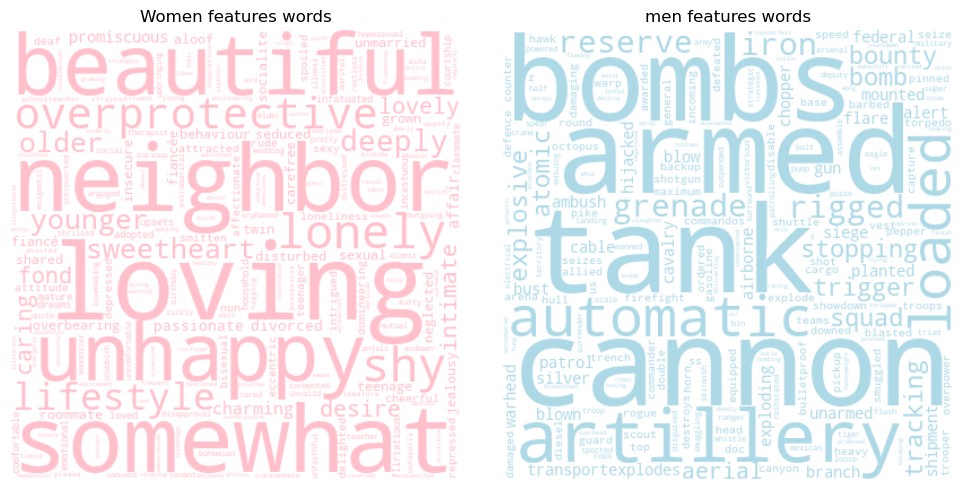

In [ ]:
similarity_diff=similaritie['Female']-similaritie['Male']
word_sim_female = {word: sim for word, sim in similarity_diff.items()}
word_sim_male = {word: -sim for word, sim in similarity_diff.items()}
plot_wordclouds(word_sim_female,word_sim_male, "wordcloud_diff_adjectives_above_50.png", "")

Here is a heat map with some of the most frequently oserved words

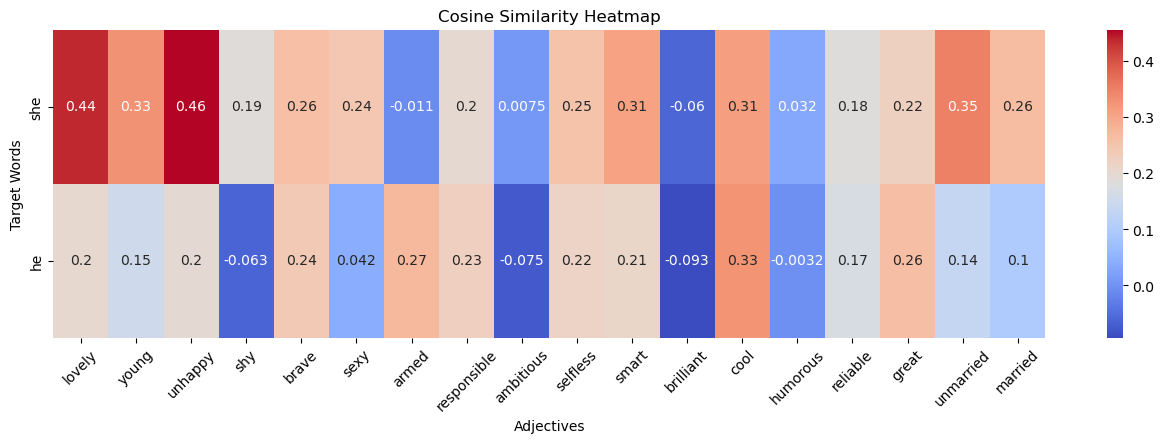

In [71]:
# heatmap
target_words = ["she", "he"]
target_words_vectors = np.array([
    vector_she,
    vector_he
])

adjectives_samples = ["lovely", "young", "unhappy", "shy", "brave", "sexy", "armed", "responsible","ambitious","selfless",
              "smart", "brilliant", "cool", "humorous", "reliable", "great","unmarried","married"]
adjectives_samples_vectors = np.array([model.wv[adj] for adj in adjectives_samples])

# cosine_similarity
cos_sim_matrix = cosine_similarity(np.vstack((target_words_vectors, adjectives_samples_vectors)))
cos_sim_matrix = cos_sim_matrix[:2, 2:]

plt.figure(figsize=(16, 4))
sns.heatmap(cos_sim_matrix, annot=True, cmap='coolwarm', xticklabels=adjectives_samples, yticklabels=target_words)
plt.title("Cosine Similarity Heatmap")
plt.ylabel("Target Words")
plt.xlabel("Adjectives")
plt.xticks(rotation=45)  # for easy reading
plt.show()

## Occupation analysis

After looking at the adjectives describing women we were wondering are women found in different jobs that men ? We used a dataset from  https://vocabularyan.com/jobs-occupation-in-english with a list of words describing common occupations and then observed which one were more correlated to women.

In [176]:
occupation_words=set()
with open('data/occupation.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                occupation_words.add(word.lower())

In [177]:
occupation_words = [word for word in occupation_words if word in model.wv.key_to_index]
occupation_vectors = [model.wv[word] for word in occupation_words]
vector_she = model.wv['she']
vector_he = model.wv['he']

In [178]:
female_reference_vector = vector_she.reshape(1, -1)
female_similarities = [cosine_similarity(female_reference_vector, vec.reshape(1, -1))[0][0] for vec in occupation_vectors]
male_reference_vector = vector_he.reshape(1, -1)
male_similarities = [cosine_similarity(male_reference_vector, vec.reshape(1, -1))[0][0] for vec in occupation_vectors]

In [179]:
similaritie = pd.DataFrame({'Female':female_similarities,'Male':male_similarities})
similaritie.index=occupation_words

In [181]:
similaritie.sort_values(ascending = False, by = "Female").head(20)

,Female,Male
nun,0.411493,0.207059
babysitter,0.377763,0.225123
doctor,0.359003,0.272354
policeman,0.318804,0.404920
pediatrician,0.314031,0.204708
waiter,0.309700,0.284876
drycleaner,0.304001,0.238613
driver,0.276681,0.317963
hairdresser,0.274848,0.107884
dancer,0.266063,0.093614


In [182]:
similarity_diff=similaritie['Female']-similaritie['Male']
top_20_female_occupation = similarity_diff.sort_values(ascending=False).head(20).index
print(top_20_female_occupation)
top_20_male_occupation = similarity_diff.sort_values(ascending=True).head(20).index
print(top_20_male_occupation)

Index(['painter', 'socialite', 'nun', 'teacher', 'composer', 'dancer',
       'student', 'hairdresser', 'gardener', 'author', 'novelist', 'pianist',
       'babysitter', 'violinist', 'singer', 'lecturer', 'writer', 'librarian',
       'poet', 'musician'],
      dtype='object')
Index(['general', 'guard', 'scout', 'deputy', 'ranger', 'marine', 'warden',
       'hunter', 'smith', 'foreman', 'soldier', 'sheriff', 'courier', 'mayor',
       'pilot', 'trainer', 'president', 'cryptographer', 'governor', 'agent'],
      dtype='object')


In [185]:
similarity_diff.sort_values(ascending=False)

painter      0.219304
socialite    0.212121
nun          0.204434
teacher      0.179721
composer     0.173483
               ...   
ranger      -0.182236
deputy      -0.184638
scout       -0.188923
guard       -0.190853
general     -0.194557
Length: 161, dtype: float32

Differences are a bit lower (around 0.21) than for the adjectives it's probably because  those words appear less often in the dataset and the model has less time to train on it. However it is still interesting to look at the difference.   

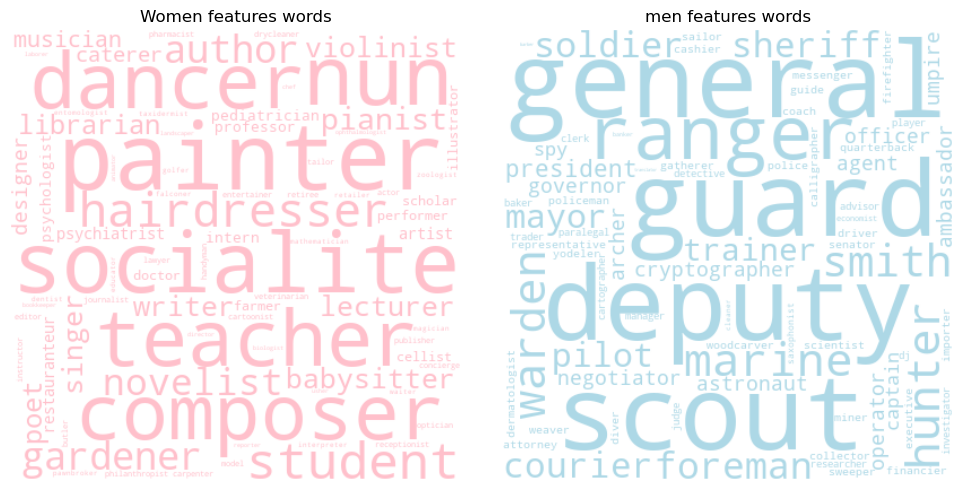

In [ ]:
word_sim_female = {word: sim for word, sim in similarity_diff.items()}
word_sim_male = {word: -sim for word, sim in similarity_diff.items()}
plot_wordclouds(word_sim_female,word_sim_male, "wordcloud_diff_occupations.png", "")

Results are expected with social norms so it is interesting.

## Sentiment analysis

Now we are wondering if women re described with different "sentiments" than men. Let's do a sentiment analysis. For this we looked at how sentimental were the words more associated to women and the ones more associated to men. However, we discoered later that sentiment analysis need context etc for a better accuracy. For this we looked at how sentimental were the words more associated to women and the ones more associated to men. However, we discoered later that sentim 

In [ ]:
#you'd better not run the code when merging cause it's time-consuming, please directly open the file sentiment_analysis_results.csv

#use to do sentiment analysis
'''

#Initialize
nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

# define analysis function
def analyze_context_in_sentence(sentence):
    # Perform syntactic analysis using spaCy
    doc = nlp(sentence)
    adjectives_with_full_context = []

    for token in doc:
        # Identify adjectives
        if token.pos_ == "ADJ":
            # The context for the adjective is the entire sentence
            full_context = sentence
            adjectives_with_full_context.append((token.text, full_context))

    return adjectives_with_full_context

# Open the file and read lines
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# List to store results
results = []

# Iterate over each movie plot summary
for i, summary in enumerate(summaries):
    # Split the plot summary into sentences
    sentences = nltk.sent_tokenize(summary.strip())

    for sentence in sentences:
        adjectives_with_full_context = analyze_context_in_sentence(sentence)

        # Perform sentiment analysis for each adjective
        for adj, full_context in adjectives_with_full_context:
            sentiment_score = sia.polarity_scores(full_context)
            results.append({
                'MovieID': i,
                'Adjective': adj,
                'Context': full_context,
                'Sentiment': sentiment_score
            })

# Save the results to a CSV file
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv('sentiment_analysis_results.csv', index=False)

'''

In [234]:
sentiment = pd.read_csv("data/sentiment_analysis_results.csv")

In [236]:
metadata = pd.read_csv("data/metadata_and_summaries_merged_cleaned.csv")

In [173]:
sentiment.columns

Index(['MovieID', 'Adjective', 'Context', 'Sentiment'], dtype='object')

In [226]:
import ast

In [244]:
similarity_and_frequency

,Word,Count,Female,Male,diff,abs_diff
0,chose,168,0.351055,0.303780,0.047275,0.047275
1,forced,3804,0.283007,0.285030,-0.002024,0.002024
2,uncontrolled,9,0.163583,0.156015,0.007568,0.007568
3,vocabulary,13,-0.001688,-0.009091,0.007403,0.007403
4,pyrokinetic,7,0.034560,0.039540,-0.004980,0.004980
...,...,...,...,...,...,...
8641,gibberish,13,0.101424,0.083571,0.017853,0.017853
8642,luckier,4,0.182658,0.124724,0.057935,0.057935
8643,sequential,6,0.067303,0.076490,-0.009188,0.009188
8644,unfreeze,6,0.244850,0.242608,0.002242,0.002242


In [235]:
sentiment.Sentiment = sentiment.Sentiment.apply(lambda x: ast.literal_eval(x))
sentiment

,MovieID,Adjective,Context,Sentiment
0,0,bizarre,"23890098\tShlykov, a hard-working taxi driver ...","{'neg': 0.09, 'neu': 0.819, 'pos': 0.091, 'com..."
1,0,different,"23890098\tShlykov, a hard-working taxi driver ...","{'neg': 0.09, 'neu': 0.819, 'pos': 0.091, 'com..."
2,1,wealthy,31186339\tThe nation of Panem consists of a we...,"{'neg': 0.156, 'neu': 0.688, 'pos': 0.156, 'co..."
3,1,poorer,31186339\tThe nation of Panem consists of a we...,"{'neg': 0.156, 'neu': 0.688, 'pos': 0.156, 'co..."
4,1,past,"As punishment for a past rebellion, each distr...","{'neg': 0.218, 'neu': 0.782, 'pos': 0.0, 'comp..."
...,...,...,...,...
701798,42305,second,"Dressed in choir surplices, they enter the chu...","{'neg': 0.0, 'neu': 0.736, 'pos': 0.264, 'comp..."
701799,42305,German,The German intruders reluctantly surrender.,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp..."
701800,42305,final,"In the final scenes,Mainwaring and the Home Gu...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
701801,42305,worse,The weather has changed for the worse and it i...,"{'neg': 0.171, 'neu': 0.829, 'pos': 0.0, 'comp..."


In [241]:
sentiment_test = sentiment.join(pd.DataFrame(dict(zip(sentiment.index,sentiment.Sentiment))).T).fillna('')

sentiment_test

,MovieID,Adjective,Context,Sentiment,neg,neu,pos,compound
0,0,bizarre,"23890098\tShlykov, a hard-working taxi driver ...","{'neg': 0.09, 'neu': 0.819, 'pos': 0.091, 'com...",0.090,0.819,0.091,0.0083
1,0,different,"23890098\tShlykov, a hard-working taxi driver ...","{'neg': 0.09, 'neu': 0.819, 'pos': 0.091, 'com...",0.090,0.819,0.091,0.0083
2,1,wealthy,31186339\tThe nation of Panem consists of a we...,"{'neg': 0.156, 'neu': 0.688, 'pos': 0.156, 'co...",0.156,0.688,0.156,0.0000
3,1,poorer,31186339\tThe nation of Panem consists of a we...,"{'neg': 0.156, 'neu': 0.688, 'pos': 0.156, 'co...",0.156,0.688,0.156,0.0000
4,1,past,"As punishment for a past rebellion, each distr...","{'neg': 0.218, 'neu': 0.782, 'pos': 0.0, 'comp...",0.218,0.782,0.000,-0.6908
...,...,...,...,...,...,...,...,...
701798,42305,second,"Dressed in choir surplices, they enter the chu...","{'neg': 0.0, 'neu': 0.736, 'pos': 0.264, 'comp...",0.000,0.736,0.264,0.7783
701799,42305,German,The German intruders reluctantly surrender.,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",0.259,0.741,0.000,-0.1027
701800,42305,final,"In the final scenes,Mainwaring and the Home Gu...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
701801,42305,worse,The weather has changed for the worse and it i...,"{'neg': 0.171, 'neu': 0.829, 'pos': 0.0, 'comp...",0.171,0.829,0.000,-0.4767


In [246]:
sentiment_and_similarity = sentiment.merge(similarity_and_frequency,left_on="Adjective",right_on = "Word", how = "inner")
sentiment_and_similarity

,MovieID,Adjective,Context,Sentiment,neg,neu,pos,compound,Word,Count,Female,Male,diff,abs_diff
0,1,wealthy,31186339\tThe nation of Panem consists of a we...,"{'neg': 0.156, 'neu': 0.688, 'pos': 0.156, 'co...",0.156,0.688,0.156,0.0000,wealthy,2285,0.124681,-0.047738,0.172419,0.172419
1,18,wealthy,The film is a surreal journey into the dreams ...,"{'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...",0.000,0.757,0.243,0.7717,wealthy,2285,0.124681,-0.047738,0.172419,0.172419
2,29,wealthy,"Anita, a wealthy and westernized heiress is co...","{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",0.000,0.828,0.172,0.3612,wealthy,2285,0.124681,-0.047738,0.172419,0.172419
3,53,wealthy,When Donald Dillingham marries the chorus gir...,"{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...",0.000,0.815,0.185,0.3612,wealthy,2285,0.124681,-0.047738,0.172419,0.172419
4,66,wealthy,This little triangle is interrupted by rich gi...,"{'neg': 0.063, 'neu': 0.646, 'pos': 0.291, 'co...",0.063,0.646,0.291,0.7943,wealthy,2285,0.124681,-0.047738,0.172419,0.172419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439563,42260,cursory,Dreyman has so far escaped all but cursory att...,"{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'comp...",0.000,0.856,0.144,0.5719,cursory,5,0.246328,0.203454,0.042874,0.042874
439564,42260,blacklisted,"At Dreyman's birthday party, his close friend ...","{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'comp...",0.000,0.789,0.211,0.7096,blacklisted,20,0.145492,0.154540,-0.009048,0.009048
439565,42260,blacklisted,"Before talking openly in his apartment, Dreyma...","{'neg': 0.064, 'neu': 0.784, 'pos': 0.152, 'co...",0.064,0.784,0.152,0.5574,blacklisted,20,0.145492,0.154540,-0.009048,0.009048
439566,42296,unreturned,"After that, he leaves, walking through dozens ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,unreturned,7,0.146251,0.162512,-0.016260,0.016260


<Axes: xlabel='diff', ylabel='pos'>

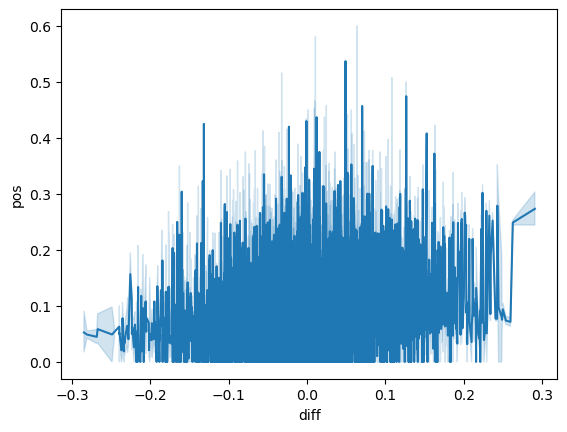

In [248]:
sns.lineplot(data = sentiment_and_similarity, x = "diff", y  = "pos")

It seems that there is a slight increase in sentiments as words get closer to women. But let's see if it is atually significant. For this we use a ordinary least square regression.

In [249]:

import statsmodels.api as sm

In [250]:
result = sm.OLS(sentiment_and_similarity["pos"], sentiment_and_similarity["diff"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    pos   R-squared (uncentered):                   0.029
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                          1.302e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                        0.00
Time:                        19:36:46   Log-Likelihood:                      2.4764e+05
No. Observations:              439568   AIC:                                 -4.953e+05
Df Residuals:                  439567   BIC:                                 -4.953e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diff           0.2407      0.002    114.098      0.000       0.237       0.245
==============================================================================
Omnibus:                    80952.980   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145377.435
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                       4.550   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-value of this OLS

In [ ]:
sentiment_and_similarity

In [ ]:
sns.boxplot(data = sentiment_and_similarity, x =  )

In [ ]:

top_100_female_adj = similaritie['Female'].sort_values(ascending=False).head(100).index
top_100_male_adj = similaritie['Male'].sort_values(ascending=False).head(100).index

top_100_female_adj_list = top_100_female_adj.astype(str).tolist()
top_100_male_adj_list = top_100_male_adj.astype(str).tolist()

print(top_100_female_adj_list)
print(top_100_male_adj_list)

Let's look at the sentiments associated with each of the words for men and for women. More sophisticated sentiment analysis models that consider context, word order, and syntactic structure are generally more accurate for analyzing sentiment in natural language. Ho

In [ ]:


sentiment_pipeline = pipeline("sentiment-analysis")


top_100_female_sentiments = sentiment_pipeline(top_100_female_adj_list)
top_100_male_sentiments = sentiment_pipeline(top_100_male_adj_list)


In [ ]:
def create_score_df(top_100_female_sentiments,top_100_male_sentiments):
    female_scores = [sentiment['score'] for sentiment in top_100_female_sentiments]
    male_scores = [sentiment['score'] for sentiment in top_100_male_sentiments]

    return pd.DataFrame({'Gender': ['Female']*len(female_scores) + ['Male']*len(male_scores),
                    'Score': female_scores + male_scores})

def plot_sentiment_box_plot(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Gender', y='Score', data=df, palette=["lightpink", "lightblue"])

    sns.swarmplot(x='Gender', y='Score', data=df, color='black', alpha=0.5)

    plt.title('Sentiment Analysis Scores for top 100 Female and Male Adjectives', fontsize=14)
    plt.ylabel('Sentiment Scores', fontsize=12)
    plt.xlabel('Gender', fontsize=12)
    plt.show()

score_df = create_score_df(top_100_female_sentiments,top_100_male_sentiments)
plot_sentiment_box_plot(score_df)

In [ ]:
def sentiment_proportions(sentiments):
    # Count the number of positive and negative sentiments
    positive = sum(1 for sentiment in sentiments if sentiment['label'] == 'POSITIVE')
    negative = sum(1 for sentiment in sentiments if sentiment['label'] == 'NEGATIVE')
    total = positive + negative
    # Calculate the proportions
    positive_proportion = positive / total
    negative_proportion = negative / total
    return positive_proportion, negative_proportion

top_100_female_positive, top_100_female_negative = sentiment_proportions(top_100_female_sentiments)
top_100_male_positive, top_100_male_negative = sentiment_proportions(top_100_male_sentiments)

print(f"Female Positive: {top_100_female_positive:.2f}, Female Negative: {top_100_female_negative:.2f}")
print(f"Male Positive: {top_100_male_positive:.2f}, Male Negative: {top_100_male_negative:.2f}")

##  Question 2: Women in Different Genres and Character Types

We wanted to know, in which Genres women are most represented and which character types they play most often.

### Question 2.1 Women in different genres - Visualization

In [6]:
dfcharacter =pd.read_csv('data/dfcharacter_cleaned.csv')
dfmetadata =pd.read_csv('data/dfmetadata_cleaned.csv')
meta_char_merged=dfcharacter[['Freebase_ID','Actor_name','Gender']].merge(dfmetadata[['Freebase_ID','Movie_name','genres']],on="Freebase_ID")

First, we re-do some of the data processing work done in milestone 2 because 
the merged dataframe was too big to push on github

In [45]:
#We need to change the type from a string representation to a dictionary
example_entry1 = meta_char_merged.genres[1]
import ast
if type(example_entry1)==str: 
    meta_char_merged.genres=meta_char_merged.genres.apply(lambda x: ast.literal_eval(x))

#Now, we can create a df where the genres are all in different columns
df_dict1 = pd.json_normalize(meta_char_merged.genres)

#We can see that the headers for genres are IDs, so let's change them to more intuitive headers.
new_column_names = []

#We will take the first most frequent not NaN mode to be the name of the column because this is also the name of the genre
for column in df_dict1.columns:
    name = df_dict1[column].mode()[0]
    new_column_names.append(name)
    
df_dict1.columns=new_column_names

#Now, we can merge the df with the genre infos to our original dataframe with the rest of the information (movie name, gender etc)
meta_char_merged2 = pd.concat([meta_char_merged.drop('genres',axis=1), df_dict1], axis=1)

Now, we are interested in how gender representation varies in different genres

In [29]:
#for this we will count the values in the genre columns
gender_counts_init = meta_char_merged2.drop(['Freebase_ID','Actor_name','Movie_name'],axis=1).groupby('Gender').count()
gender_counts=gender_counts_init.transpose()
#Adding some new columns
#First, i want one for the total counts to later look at the most common genres
gender_counts['total_count']=gender_counts.F+gender_counts.M
#Next, we are also also interested in the percentage of women
gender_counts['F_percentage']=(gender_counts.F/(gender_counts.F+gender_counts.M))*100

#Finally, we want reset the index so that genre is a normal column:
gender_counts_2=gender_counts.reset_index()
gender_counts_2=gender_counts_2.rename(columns={'index':'Genre'})

gender_counts_2

Gender,Genre,F,M,total_count,F_percentage
0,Thriller,21266,48150,69416,30.635588
1,Science Fiction,6626,16349,22975,28.840044
2,Horror,11659,21127,32786,35.560910
3,Adventure,9715,27064,36779,26.414530
4,Supernatural,1951,3299,5250,37.161905
...,...,...,...,...,...
356,Revenge,2,6,8,25.000000
357,Romantic thriller,1,0,1,100.000000
358,Chick flick,8,10,18,44.444444
359,Buddy Picture,7,29,36,19.444444


In [46]:
#Since many genres don't have a lot of data, we take a look at the 20 biggest Genres:
mostcommon=gender_counts_2.sort_values(by='total_count',ascending=False).head(20)
#sorting by female percentage
mostcommon=mostcommon.sort_values(by='F_percentage',ascending=False)

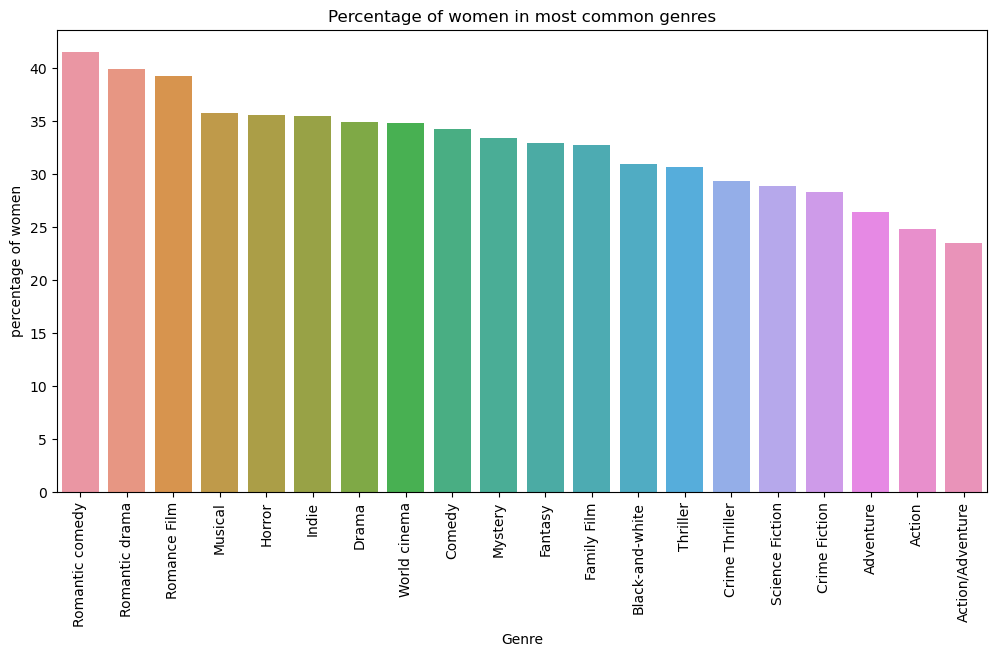

In [47]:
#Making plot
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='Genre',y="F_percentage", data=mostcommon)
ax = plt.title("Percentage of women in most common genres")
ax = plt.ylabel("percentage of women")
ax = plt.xticks(rotation=90) 

In [49]:
#Making a pretty interactive plot for the website
#Defining some shades of pink
pink_scale = [
    [0.0, 'rgb(255, 228, 225)'],[0.2, 'rgb(255, 182, 193)'],[0.4, 'rgb(255, 105, 180)'],[0.6, 'rgb(255, 20, 147)'],  
    [0.8, 'rgb(199, 21, 133)'],[1.0, 'rgb(139, 10, 80)']     
]

#Making plot
fig = px.bar(mostcommon, x='Genre', y='F_percentage',
             hover_data=['F', 'M'],
             color='F_percentage',  # Using F_percentage for color gradient
             color_continuous_scale=pink_scale)

# Customizing layout
fig.update_layout(title="Percentage of Women Represented in Different Genres",xaxis_title="Genre",
    yaxis_title="Percentage of Women",plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#333"
    )
)

fig.update_layout(width=900, height=600)
# Hiding color scale
fig.update_layout(coloraxis_showscale=False)
fig.write_html("figures/Genres_Pink.html")

### Question 2.1 Women in different Genres - Statistics

Next, we want to see if the effect of character types on gender they are played by is significant. Since gender is binary (F/M) and genres is categorical, we performed a chi square test:

In [50]:
#Doing a chi suqare test

#Creating contingency table:
df_Genre_FM = gender_counts_2[['Genre', 'F', 'M']]
df_pivoted = df_Genre_FM.pivot_table(index='Genre', values=['F', 'M'])
df_contingency = df_pivoted.T

#Removing columns where M or F is zero because else the chi square test doesn't work.
df_contingency = df_contingency.loc[:, ~(df_contingency == 0).any(axis=0)]

# Performing chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(df_contingency)


print("Chi-square statistic:", chi2)
print("P-value: {:.2e}".format(p))
print("Degrees of freedom:", dof)

Chi-square statistic: 18841.717731398014
P-value: 0.00e+00
Degrees of freedom: 354


### Question 2.2 Women playing different character types - Visualization

We want to know which character types women play most often.

In [56]:
clusters_merged = pd.read_csv("data/clusters_merged_cleaned.csv")

#grouping by type and gender
types = clusters_merged.groupby(['type', 'Gender']).size().unstack(fill_value=0)

#adding a column for total M+F to see which types are most comon
types['total_count'] = types['F'] + types['M']

#adding a column for the percentage of women
types['F_percentage'] = (types['F'] / (types['F'] + types['M']))*100

# Resetting index to make 'type' a column
types.reset_index(inplace=True)

types.sort_values(by='F_percentage',ascending=False).head(15)

Gender,type,F,M,total_count,F_percentage
69,valley_girl,6,0,6,100.000000
53,prima_donna,6,0,6,100.000000
51,ophelia,5,0,5,100.000000
44,junkie_prophet,2,0,2,100.000000
12,chanteuse,6,0,6,100.000000
15,classy_cat_burglar,1,0,1,100.000000
34,final_girl,6,0,6,100.000000
27,dumb_blonde,10,1,11,90.909091
6,broken_bird,4,1,5,80.000000
5,brainless_beauty,7,5,12,58.333333


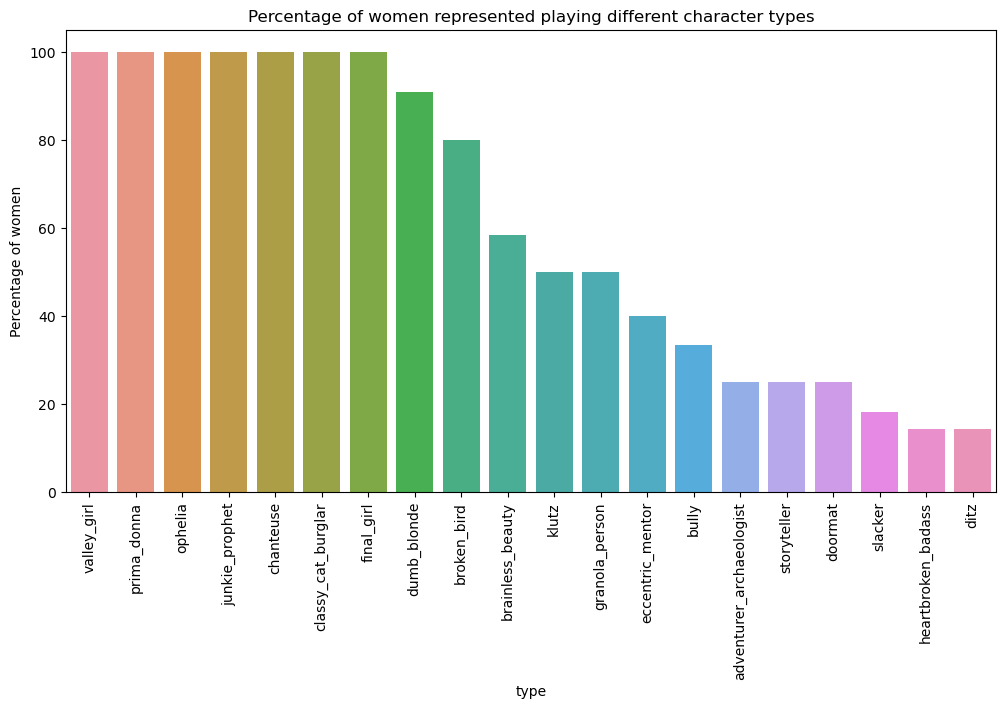

In [58]:
#Making plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='type',y="F_percentage", data=types.sort_values(ascending=False,by='F_percentage').head(20))
ax = plt.title("Percentage of women represented playing different character types")
ax = plt.ylabel("Percentage of women")
ax = plt.xticks(rotation=90) 

We can see that women are most represented in character types such as "valley girl" or "prima donna", and less in types such as "adventurer archaeologist". However, it is important to note that the clusters data is very short, so this is not very meaningful. Nevertheless, we thought it was interesting to see. Maybe in future analyses we can expand on the different character types or create our own. 

In [65]:
#Making a fancier interactive plot for the website

pastel_pink = '#FFC0CB'  # A shade of pastel pink
pastel_blue = '#ADD8E6'  # A shade of pastel blue

#Sorting the calues
types_sorted = types.sort_values(by='M', ascending=False)
types_sorted = types_sorted.sort_values(by='F', ascending=True, kind='mergesort')

#Removing underscores for prettier labels
types_sorted['type'] = types_sorted['type'].str.replace('_', ' ')


#Adjusting figure height
fig_height = len(types_sorted['type']) * 25  # 25 pixels per type

# Creating figure
fig = go.Figure()

# Adding the bar for women (negative values for left direction)
fig.add_trace(go.Bar(y=types_sorted['type'], x=-types_sorted['F'], name='Women', orientation='h',marker_color=pastel_pink))

# Adding the bar for men (positive values for right direction)
fig.add_trace(go.Bar(y=types_sorted['type'], x=types_sorted['M'], name='Men', orientation='h',marker_color=pastel_blue))

# Adjusting x tick labels to not show negative values as they don't make sense for counts
tick_values = [-10, -5, 0, 5, 10, 15, 20, 25]
tick_labels = ['10', '5', '0', '5', '10', '15', '20', '25']

# Customizing layout
fig.update_layout(
    title="Number of men and women playing different character types",
    xaxis_title="Count",
    yaxis_title="Type",
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(family="Arial, sans-serif", size=12, color="#333"),
    barmode='relative',
    bargap=0.15,
    height=fig_height,  # Set figure height
    xaxis=dict(
        tickmode='array',
        tickvals=tick_values,
        ticktext=tick_labels
    )
)

fig.write_html("figures/types_wholeplot.html")

### Question 2.2 Women playing different character types - Statistics

Next, we want to see if the effect of character types on gender they are played by is significant. Since gender is binary (F/M) and character types is categorical, we performed a chi square test:

In [66]:
#Doing a chi squared test

#Creating contingency table
contingency_table = pd.crosstab(clusters_merged['Gender'], clusters_merged['type'])

#Performing chi squared test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-squared statistic: 369.8513527525936
P-value: 5.592160386860096e-42


We can see that the gender difference when playing different character types is very significant! P-value 5.59e-42 (<<0.05). However, as noted before, the dataset for character types is very small, so this result needs to be taken with a grain of salt.

##  Question 3: Evolution of Female Protagonists

Now, we will look at the data to check whether the amount of movies starring female protagonists changed over time. At first, we will find how many times a character name is used in summaries. Then, we will only focus on the character names that are mentioned the most in the movie summary so that we can define the protagonists. 

In [186]:
#merging summaries with the characters

summary_and_movie = pd.read_csv("data/metadata_and_summaries_merged_cleaned.csv")
character_with_name=pd.read_csv("data/character_with_name_cleaned.csv")

movie_summary_char_merged = summary_and_movie[['Freebase_ID','test','Movie_name','Summary']].merge(character_with_name [['Character_name','Freebase_ID','Gender']] ,on="Freebase_ID",how ='right').dropna()
movie_summary_char_merged=movie_summary_char_merged[movie_summary_char_merged['test'] != 'nan']

In [187]:
#counting the number of character names occurence in summaries
def count_characters(row): 
    char_count = row['Character_name'] 
    summary_search = row['Summary'] 
    return summary_search.count(char_count)

#finding the number of women/men characters 

movie_summary_char_merged.loc[:,'Count_of_Char']= movie_summary_char_merged.apply(count_characters,axis=1).dropna()

We have a dataframe with the number of character. In order to look at the changes of the number of characters in years. We will calculate the percentage of female characters in movie summaries.

Since the time horizon is too long, we decided to divide data to 10 years periods. We will now group the data according the periods and find the percentage of female/male characters in movie summaries.

In [188]:
#finding 10-year periods of data and creating new column named 'period'

movie_summary_char_merged.loc[:,'test']=pd.to_numeric(movie_summary_char_merged['test'],errors='coerce').fillna(0).astype('int')
movie_summary_char_merged.loc[:,'period'] = pd.cut(movie_summary_char_merged['test'], bins=range(1010, 2020, 10))
movie_summary_char_merged.loc[:,'period']=movie_summary_char_merged.loc[:,'period'].astype('str').replace('(', '').replace(']', '')
movie_summary_char_merged=movie_summary_char_merged[movie_summary_char_merged['period'] != 'nan']

#grouping data to periods and finding the percentage of female/male characters in summaries

movie_summary_char_merged_grouped = movie_summary_char_merged.groupby(['period','Gender']).sum('Count_of_Char').dropna()
movie_summary_char_merged_grouped['Percentage'] = movie_summary_char_merged_grouped.groupby('period')['Count_of_Char'].transform(lambda x: (x / x.sum()) * 100).dropna()
movie_summary_char_merged_grouped=movie_summary_char_merged_grouped.reset_index()
movie_summary_char_merged_grouped=movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['period'] != 'nan']

In [189]:
#replacing paranthesis in period names and changing the format

def format_period(period):
    return period.replace('(', '').replace(']', '').replace(', ', '-')

movie_summary_char_merged_grouped['period']=movie_summary_char_merged_grouped['period'].apply(format_period)

Now that we have reached the data, we can visualize it with colorful graphs to see whether there is a change in the percentage of female/male characters mentioned in movie summaries.

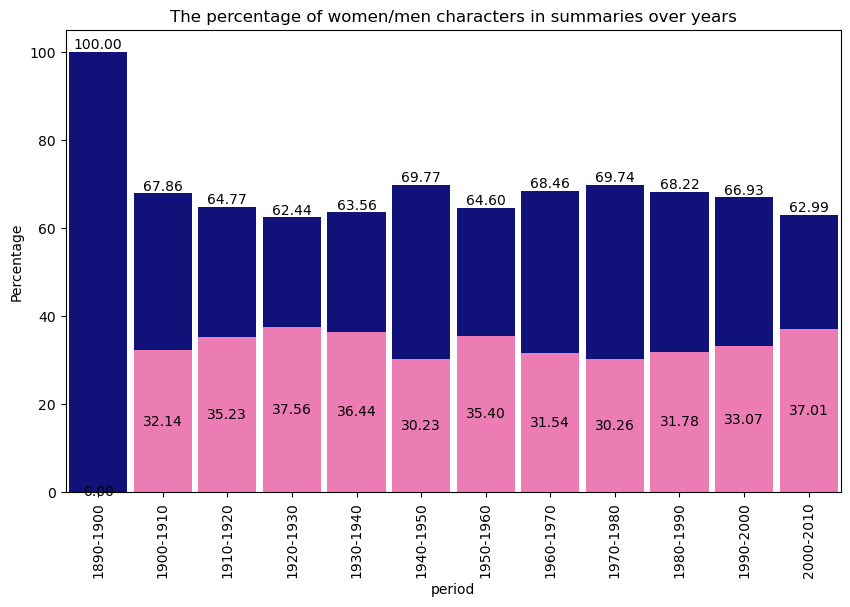

In [190]:
#creating a bar chart showing the percentage of women characters in movies over the years

plt.figure(figsize=(10, 6)) 
plt.title("The percentage of women/men characters in summaries over years")
plt.ylabel("The percentage of women/men characters in summaries")
plt.xticks(rotation=90)

ax = sns.barplot(x= 'period',y="Percentage", data=movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['Gender']== 'M'], color='darkblue',width=0.9)
ax.bar_label(ax.containers[0],fmt='%.2f')

ax = sns.barplot(x='period', y='Percentage', data=movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['Gender']== 'F'], color= 'hotpink', width=0.9)
ax.bar_label(ax.containers[1],label_type='center',fmt='%.2f')

ax.get_legend()

When we look at the graph, there is not a significant change in the female characters over decades. Female characters constitute only the 30-35% percentage of the protagonists represented in movie summaries. To extent our interpretation, we decided to shorten the time interval in each period. Now, we will look at the data for 5-year periods.

In [191]:
#grouping yearly data by periods and creating new column named 'period'
movie_summary_char_merged.loc[:,'period'] = pd.cut(movie_summary_char_merged['test'], bins=range(1010, 2020, 5))
movie_summary_char_merged.loc[:,'period']=movie_summary_char_merged.loc[:,'period'].astype('str')

#grouping data to periods and finding the percentage of female/male protagonists

movie_summary_char_merged_grouped = movie_summary_char_merged.groupby(['period','Gender']).sum('Count_of_Char')
movie_summary_char_merged_grouped['Percentage'] = movie_summary_char_merged_grouped.groupby('period')['Count_of_Char'].transform(lambda x: (x / x.sum()) * 100)
movie_summary_char_merged_grouped=movie_summary_char_merged_grouped.reset_index()
movie_summary_char_merged_grouped= movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['period'] != 'nan'].dropna()

In [192]:
#replacing paranthesis in period names and changing the format
def format_period(period):
    return period.replace('(', '').replace(']', '').replace(', ', '-')

movie_summary_char_merged_grouped['period']=movie_summary_char_merged_grouped['period'].apply(format_period)

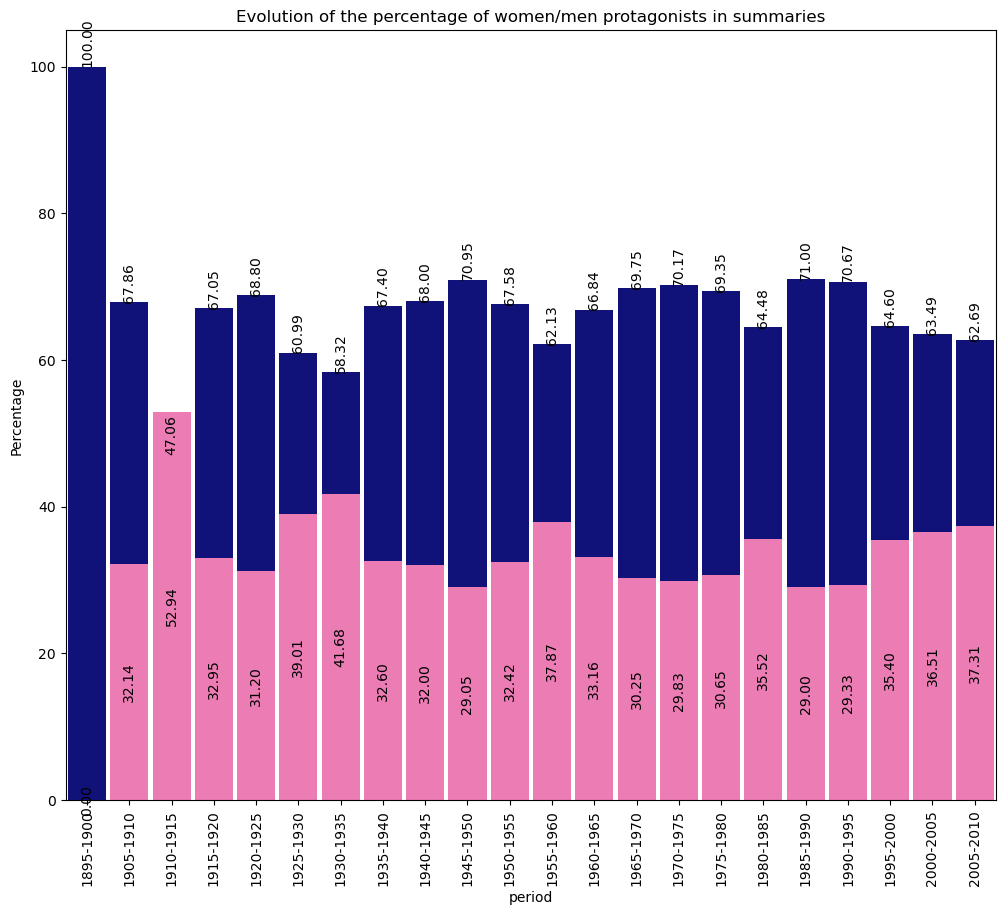

In [193]:
#creating a bar chart showing the percentage of women characters in movies over the years (5-year periods)

plt.figure(figsize=(12, 10)) 
plt.title("Evolution of the percentage of women/men protagonists in summaries")
plt.ylabel("the percentage of women/men protagonists mentioned in summaries")
plt.xticks(rotation=90)


ax = sns.barplot(x= 'period',y="Percentage", data=movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['Gender']== 'M'], color='darkblue',width=0.9)
ax.bar_label(ax.containers[0],fmt='%.2f',rotation=90)

ax = sns.barplot(x='period', y='Percentage', data=movie_summary_char_merged_grouped[movie_summary_char_merged_grouped['Gender']== 'F'], color= 'hotpink', width=0.9)
ax.bar_label(ax.containers[1],label_type='center',fmt='%.2f',rotation=90)

ax.get_legend()


As we can see, the number of female characters in summaries reached its peak at 62.96% in 1900-1905. When we searched this time period we learned that during the 1910s, women's increasing involvement in the film industry as actors, screenwriters, theater managers, film producers, and directors paralleled the increasing number of women in American workplaces and also vocal and energetic women's suffrage movement effort. The increase in the number of female chacaters in movie summary can be related to this historical movements.

(https://www.theatlantic.com/entertainment/archive/2016/03/the-forgotten-female-action-stars-of-the-1910s/475635/)

Till now we have analysed the percentage of female characters that are represented in movie summaries. We saw that the number of female characters have not significantly changed over years. However, we want to learn more about the change of females representation on movie summaries. 

Therefore, now we will find the protagonists of the movies and see whether there is a change in the precentage of female protagonists reprsented in movie summaries over time.
The protagonist of the movie is defined as the character which is mostly mentioned in the summary. 

In [194]:
#finding the percentage of each character in movie summaries to determine which character is protagonist
movie_summary_char_merged = movie_summary_char_merged [movie_summary_char_merged ['Count_of_Char']>0]
movie_summary_char_merged['%'] = movie_summary_char_merged.groupby('Movie_name')['Count_of_Char'].transform(lambda x: (x / x.sum()) * 100)

In [195]:
#extracting only protagonist and creating new data frame including only protagonists
protagonists_indices = movie_summary_char_merged.groupby('Movie_name')['%'].idxmax()
movie_summary_char_merged_protagonists =movie_summary_char_merged .loc[protagonists_indices]

In [196]:
#grouping data to genders
movie_summary_char_merged_grouped_protagonists=movie_summary_char_merged_protagonists.groupby('Gender').sum()
movie_summary_char_merged_grouped_protagonists=movie_summary_char_merged_grouped_protagonists.reset_index()

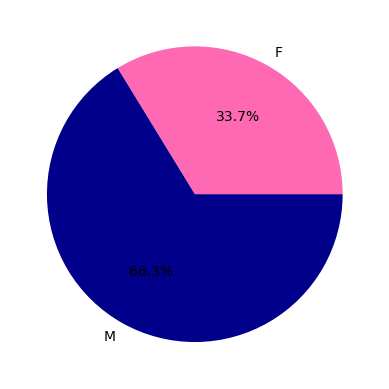

In [197]:
#creating a pie chart that shows the percentage of female/male protagonists in movie summaries overall
fig, ax = plt.subplots()
ax.pie(movie_summary_char_merged_grouped_protagonists['Count_of_Char'],labels=movie_summary_char_merged_grouped_protagonists['Gender'],colors=['hotpink','darkblue'],autopct='%1.1f%%')
ax.get_legend()

The result are quite close to what we found previously in the number of female characters in movie summaries. However, we will proceed to find answers to our research question "Did the amount of movies starring female protagonists change over time?". Therefore, now we will group the data according to periods and look at the change in the percentage of female/male protagonists respresented in movie summaries. We will divide the time interval again as periods to see the change over decades.

In [42]:
#grouping the dataframe into periods 
movie_summary_char_merged_protagonists_grouped = movie_summary_char_merged_protagonists.groupby(['period','Gender']).size()
movie_summary_char_merged_protagonists_grouped = movie_summary_char_merged_protagonists_grouped.reset_index(name='Count_of_movies')
movie_summary_char_merged_protagonists_grouped['Percentage'] = movie_summary_char_merged_protagonists_grouped.groupby('period')['Count_of_movies'].transform(lambda x: (x / x.sum()) * 100)

In [43]:
#replacing paranthesis in period names and changing the format
def format_period(period):
    return period.replace('(', '').replace(']', '').replace(', ', '-')

movie_summary_char_merged_protagonists_grouped['period']=movie_summary_char_merged_protagonists_grouped['period'].apply(format_period)

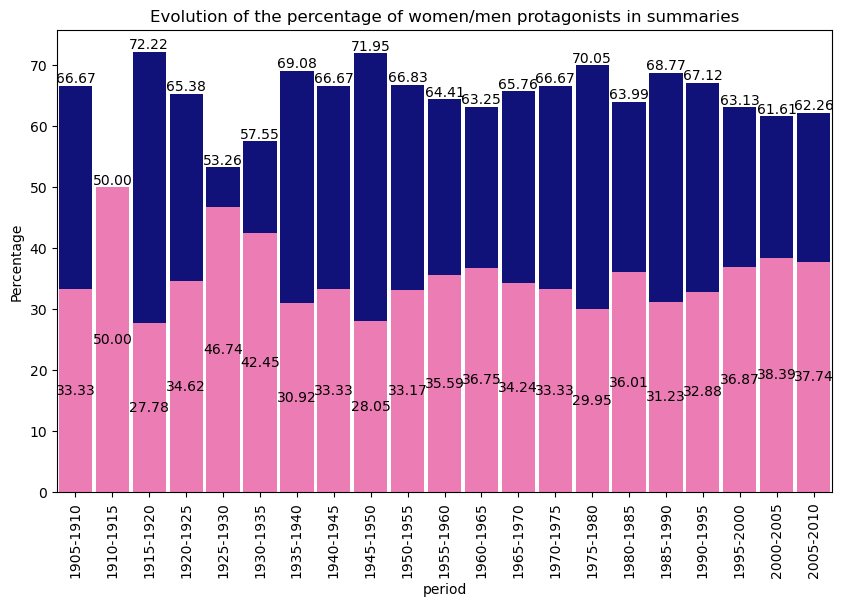

In [44]:
#creating a bar chart showing the percentage of women protagonists in movies over the years
plt.figure(figsize=(10, 6)) 
plt.title("Evolution of the percentage of women/men protagonists in summaries")
plt.ylabel("the percentage of women/men protagonists mentioned in summaries")
plt.xticks(rotation=90)

ax = sns.barplot(x= 'period',y="Percentage", data=movie_summary_char_merged_protagonists_grouped[(movie_summary_char_merged_protagonists_grouped['Gender']== 'M')&(movie_summary_char_merged_protagonists_grouped['period']>='1900-1910')] , color='darkblue',width=0.9)
ax.bar_label(ax.containers[0],fmt='%.2f')
ax = sns.barplot(x='period', y='Percentage', data=movie_summary_char_merged_protagonists_grouped[movie_summary_char_merged_protagonists_grouped['Gender']== 'F'], color= 'hotpink', width=0.9)
ax.bar_label(ax.containers[1],label_type='center',fmt='%.2f')

ax.get_legend()

Now, we can see that female protagonists in movie summaries also have not evolved significantly over the years. There is a noticeable increase in female protagonists reaching the highest in 1920-1930 which may be the result of vocal and energetic women's suffrage movement effort that we mentioned previously in our character count analysis.

We have already learned a lot from the data. Movie summaries showed us that females' appearance in movies as both characters and protagonists has not changed significantly. Female characters and protagonists' appearance were always less than the males in movies.

Now that we know females are less involved than men in movies, we will ask the last part of our question: How have the adjectives representing women changed over time? To answer this question we will look at the change of adjectives that is used more for females than males.

In [45]:
#grouping data to periods
dfsummaries_period = dfsummaries.merge(summary_and_movie[['Wikipedia_ID','test']] ,on="Wikipedia_ID",how ='left').dropna()
dfsummaries_period.loc[:,'test']=pd.to_numeric(dfsummaries_period['test'],errors='coerce').fillna(0).astype('int')
dfsummaries_period.loc[:,'period'] = pd.cut(dfsummaries_period['test'], bins=range(1900, 2030, 10))


In [ ]:
dfsummaries_period['period']= dfsummaries_period['period'].astype("str").apply(format_period)
dfsummaries_period = dfsummaries_period[dfsummaries_period["period"]!='nan']
dfsummaries_period["cleaned_summary"]  = dfsummaries_period["Summary"].apply(lambda x : preprocess_text(x))